# Gold Price Time Series Analysis - Part 2
## Time Series Analysis Concept
An explanatory model is useful because it incorporates information about other variables, rather than only historical values of the variable to be forecast. https://otexts.com/fpp2/data-methods.html

However, there are several reasons that time series model should be adopted :
1. It is difficult to measure the relationships between variables and our target (y)
2. It is difficult to forecast the future values of all variables (Xs) in order to predict y
3. The main concern is to forecast, not to know what variables can predict y
4. Time series model may produce more accurate forecasts than a explanatory or mixed model

### Steps
1.	Decomposition
2.	Autocorrelation (ACF PACF plots)
3.	Stationarity 
    - Dickey-fuller test
    - Differencing
4.	Types of time series models
    - Exponencial smoothing
    - Classical time series models - ARIMA
    - Deep learning models – LSTM
5.	Time series models evaluation
    - Time series metrics : RMSE
    - Time series train test split

**Important Notes**
1. Need to set datetimeIndex frequency, otherwise, there will be errors 
https://stackoverflow.com/questions/71647632/how-to-add-frequency-information-to-date-index-in-arima-model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

df = pd.read_csv("/Users/emilychaukang/Desktop/DS/DS Projects/2. Gold Price Time Series Analysis/df.csv",index_col='Date',parse_dates=True)

## Data Preparation 

In [2]:
df

,XAU,GF,SPDR,Brent Oil,Crude Oil,S&P GSCI,S&P 500,USD Index,Interest rate,GDP growth
Date,,,,,,,,,,
2013-01-01,1675.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,NaN
2013-01-02,1686.75,1688.80,163.17,112.47,93.12,4934.19,1462.42,79.85,0.17,NaN
2013-01-03,1663.35,1674.60,161.20,112.14,92.92,4915.25,1459.37,80.43,0.17,NaN
2013-01-04,1656.85,1648.90,160.44,111.31,93.09,4889.98,1466.47,80.50,0.16,NaN
2013-01-07,1647.25,1646.30,159.43,111.40,93.19,4905.04,1461.89,80.26,0.16,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-16,1891.76,1928.30,175.57,83.45,79.38,3484.20,4404.33,103.42,5.33,NaN
2023-08-17,1888.89,1915.20,175.30,84.12,80.39,3506.70,4370.36,103.44,5.33,NaN
2023-08-18,1888.19,1916.50,175.33,84.80,81.25,3536.75,4369.71,103.38,NaN,NaN


In [3]:
# We only need XAU price (univariate)
tdf = df['XAU'].to_frame()
tdf

,XAU
Date,
2013-01-01,1675.15
2013-01-02,1686.75
2013-01-03,1663.35
2013-01-04,1656.85
2013-01-07,1647.25
...,...
2023-08-16,1891.76
2023-08-17,1888.89
2023-08-18,1888.19


In [4]:
# Drop missing values because we can't have them when performing ETS
tdf.dropna(inplace=True)

In [5]:
# Double check whether there is no missing values
tdf.isnull().sum()

XAU    0
dtype: int64

In [6]:
tdf.head()

,XAU
Date,
2013-01-01,1675.15
2013-01-02,1686.75
2013-01-03,1663.35
2013-01-04,1656.85
2013-01-07,1647.25


In [7]:
tdf.describe()

,XAU
count,2770.000000
mean,1467.752664
std,275.409775
min,1051.740000
25%,1247.110000
50%,1327.245000
75%,1756.667500
max,2063.810000


In [8]:
# Make sure the index is in order
tdf.sort_index(inplace=True)

In [9]:
# frequency = None
# 2770 rows
tdf.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-14',
               ...
               '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-14',
               '2023-08-15', '2023-08-16', '2023-08-17', '2023-08-18',
               '2023-08-20', '2023-08-21'],
              dtype='datetime64[ns]', name='Date', length=2770, freq=None)

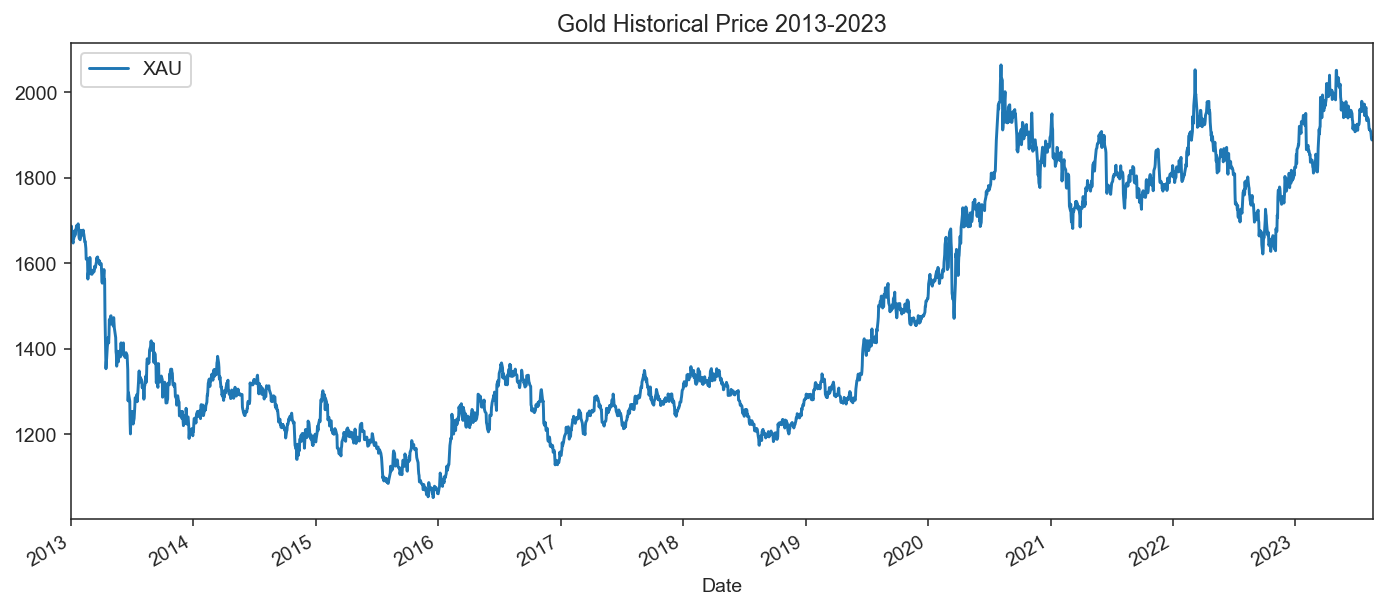

In [10]:
plt.rcParams["figure.dpi"] = 140
sns.set_style('ticks')
ax = tdf['XAU'].plot.line(figsize=(12,5),title='Gold Historical Price 2013-2023')
ax.autoscale(axis='x',tight=True)
# Locate legend on top left
ax.legend(loc=2);

### Set Frequency for DatetimeIndex
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [11]:
# Gold is mostly traded on business days
# Resample our data to include all business days
test = tdf.resample("B").sum()
print(f'# of rows after resampling: {len(test)}')
# Check the index of rows with 0 value
interp = test[test['XAU']==0]
interp

# of rows after resampling: 2775


,XAU
Date,
2013-03-29,0.0
2014-12-25,0.0
2018-03-30,0.0
2018-12-25,0.0
2019-04-19,0.0
2023-04-07,0.0


After resampling, there are 2775 rows, which are five more rows before resampling. Something must be wrong because the total number of rows should be 2776, including 6 new rows of 0 values added to our data. Later I found out that when frequency is set to "B"(business day), and there are weekends(Saturdays or Sundays) presented in the data, the weekend day's value will be combined with that of the previous day. 

In [12]:
# Make a new column to show day in a week
# dt.dayofweek 0 = Monday, 6 = Sunday
# There is a sunday in our data
tdf['Day(W)'] = tdf.index.dayofweek
Sat = tdf[tdf['Day(W)'] == 5]
Sun = tdf[tdf['Day(W)'] == 6]
print(f"Sat : {len(Sat)}")
print(f"Sun : {len(Sun)}")

Sat : 0
Sun : 1


In [13]:
tdf[tdf['Day(W)'] == 6]

,XAU,Day(W)
Date,,
2023-08-20,1890.08,6


In [14]:
# We can see that 8/18 has an abnormal value after sampling
# 8/18 is a friday
test.loc['2023-08-15':'2023-08-25']

,XAU
Date,
2023-08-15,1901.56
2023-08-16,1891.76
2023-08-17,1888.89
2023-08-18,3778.27
2023-08-21,1894.44


In [15]:
# The original value of 8/18 is 1888.19
# Since 8/20 is a Sunday, its value was combined with 8/18 after sampling
tdf.loc['2023-08-15':'2023-08-25']

,XAU,Day(W)
Date,,
2023-08-15,1901.56,1
2023-08-16,1891.76,2
2023-08-17,1888.89,3
2023-08-18,1888.19,4
2023-08-20,1890.08,6
2023-08-21,1894.44,0


In [16]:
len(tdf)

2770

In [17]:
# drop the sunday's value from the original data
tdf = tdf.drop('2023-08-20',axis=0)
len(tdf)

2769

In [18]:
# Resample the data after dropping the sunday value
ndf = tdf.resample("B").sum()
print(f'# of rows after resampling: {len(test)}')
# Check the index of rows with 0 value
interp = ndf[ndf['XAU']==0].index
interp

# of rows after resampling: 2775


DatetimeIndex(['2013-03-29', '2014-12-25', '2018-03-30', '2018-12-25',
               '2019-04-19', '2023-04-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

Now, we already delete a row from 2770, then added 6 missing business days into our data. The total number of rows should be 2775, which is correct. 

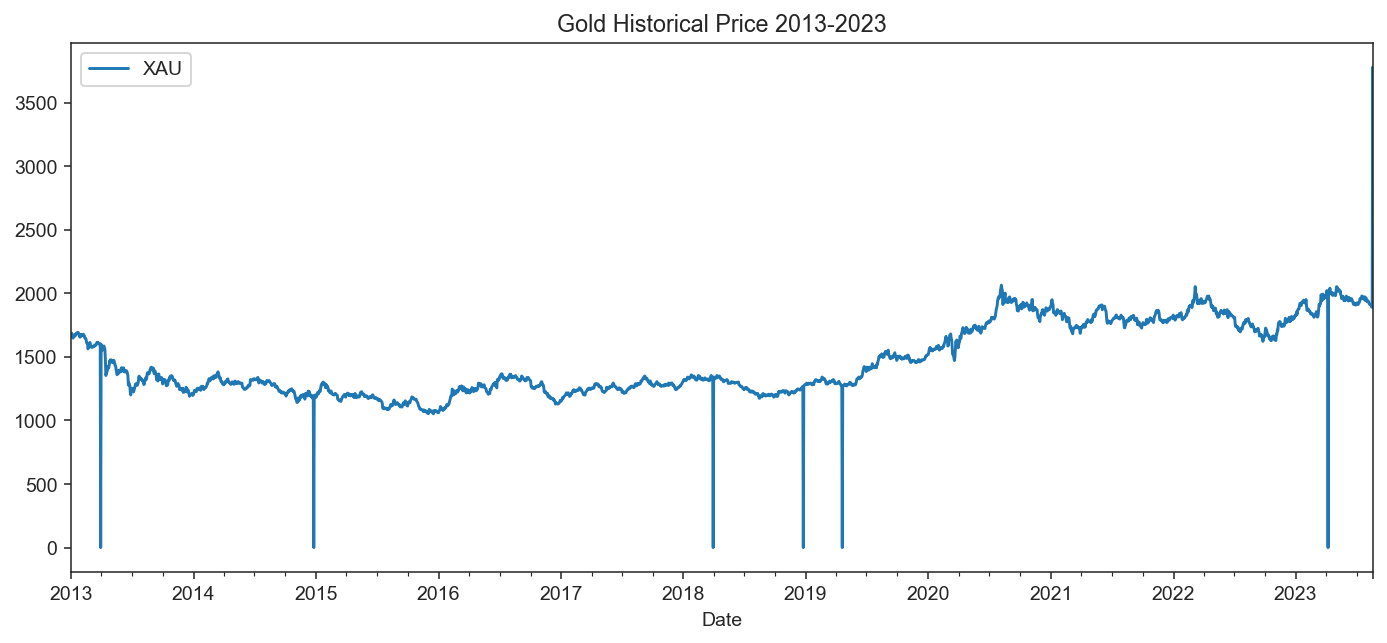

In [19]:
# We can see there are 6 zero value added 
plt.rcParams["figure.dpi"] = 140
sns.set_style('ticks')
ax = test['XAU'].plot.line(figsize=(12,5),title='Gold Historical Price 2013-2023')
ax.autoscale(axis='x',tight=True)
# Locate legend on top left
ax.legend(loc=2);

In [20]:
# Set tdf equal to test and drop the Day(W) column(not needed anymore)
tdf = ndf.drop("Day(W)",axis=1)
# Replace 0 with NaN values
tdf['XAU'].replace(0, np.nan,inplace=True)

In [21]:
# Check there are six NaN value
tdf.isnull().sum()

XAU    6
dtype: int64

In [22]:
# Fill NaN 
tdf['XAU'].fillna(tdf['XAU'].interpolate(),inplace=True)

In [23]:
# Now, there is no missing data and the frequency of time series is BusinessDay
print(f"# of rows : {len(tdf)}")
print(f"Missing rows : {tdf.isnull().sum()[0]}")
print(f"Frequency: {tdf.index.freq}")

# of rows : 2775
Missing rows : 0
Frequency: <BusinessDay>


In [24]:
# Remember the prepared data is called tdf
tdf.loc[interp]

,XAU
Date,
2013-03-29,1597.820
2014-12-25,1184.600
2018-03-30,1333.175
2018-12-25,1268.055
2019-04-19,1275.155
2023-04-07,1998.835


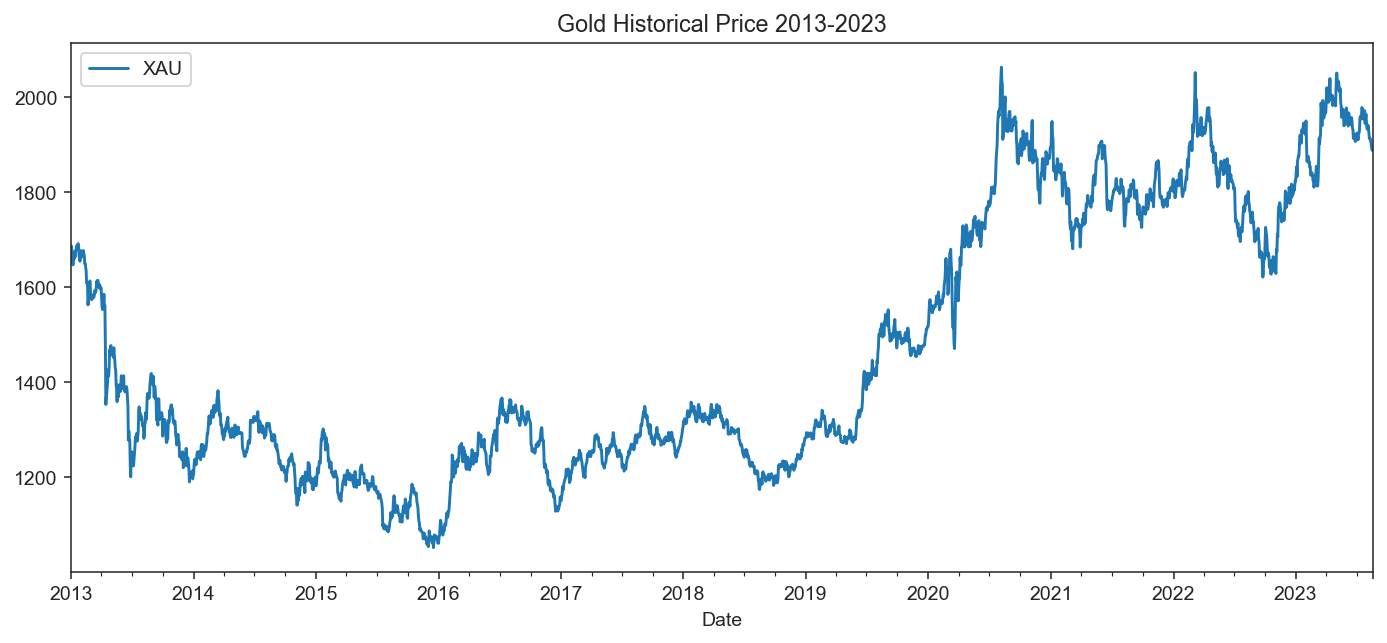

In [25]:
plt.rcParams["figure.dpi"] = 140
sns.set_style('ticks')
ax = tdf['XAU'].plot.line(figsize=(12,5),title='Gold Historical Price 2013-2023')
ax.autoscale(axis='x',tight=True)
# Locate legend on top left
ax.legend(loc=2);

## ETS decomposition 

- Trend : Slow moving changes in a time series, Responsible for making series gradually increase or decrease over time.
- Seasonality - Seasonal Patterns in the series. The cycles occur repeatedly over a fixed period of time.
- Errors/Residuals - The behavior of the time series that cannot be explained by the trend and seasonality components. Also called random errors/white noise.

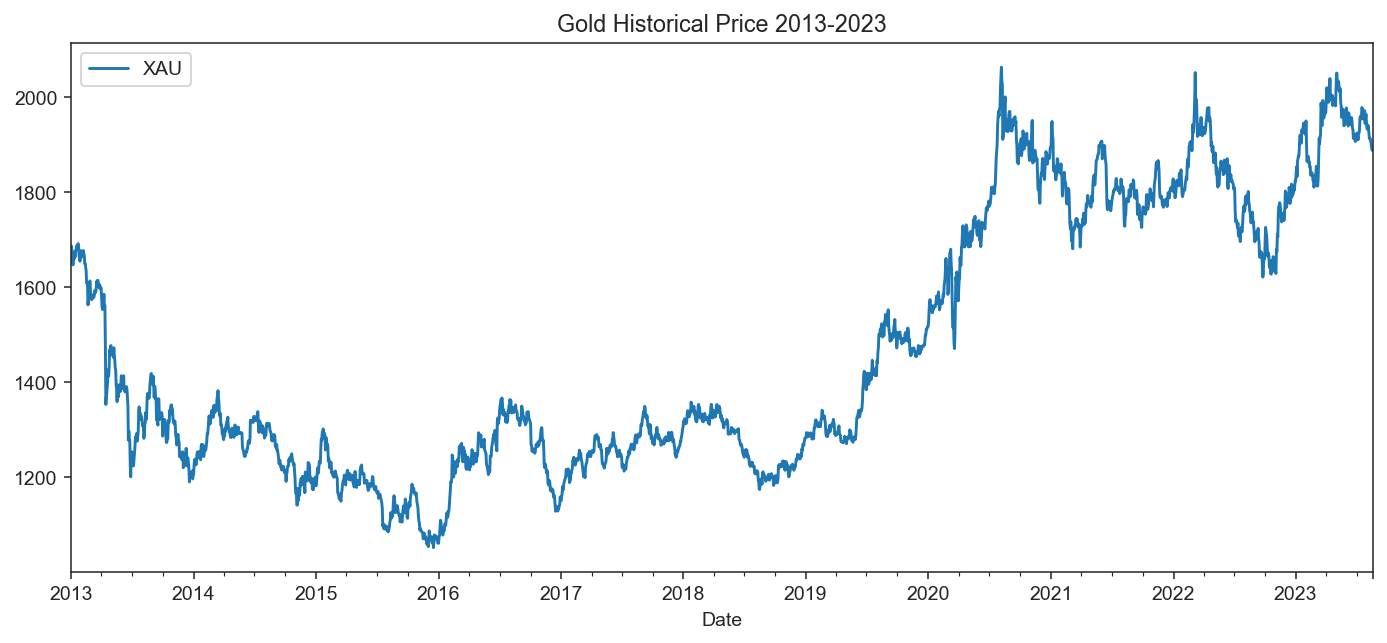

In [26]:
plt.rcParams["figure.dpi"] = 140
sns.set_style('ticks')
ax = tdf['XAU'].plot.line(figsize=(12,5),title='Gold Historical Price 2013-2023')
ax.autoscale(axis='x',tight=True)
# Locate legend on top left
ax.legend(loc=2);

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
add = seasonal_decompose(tdf,model = 'add',period=240)

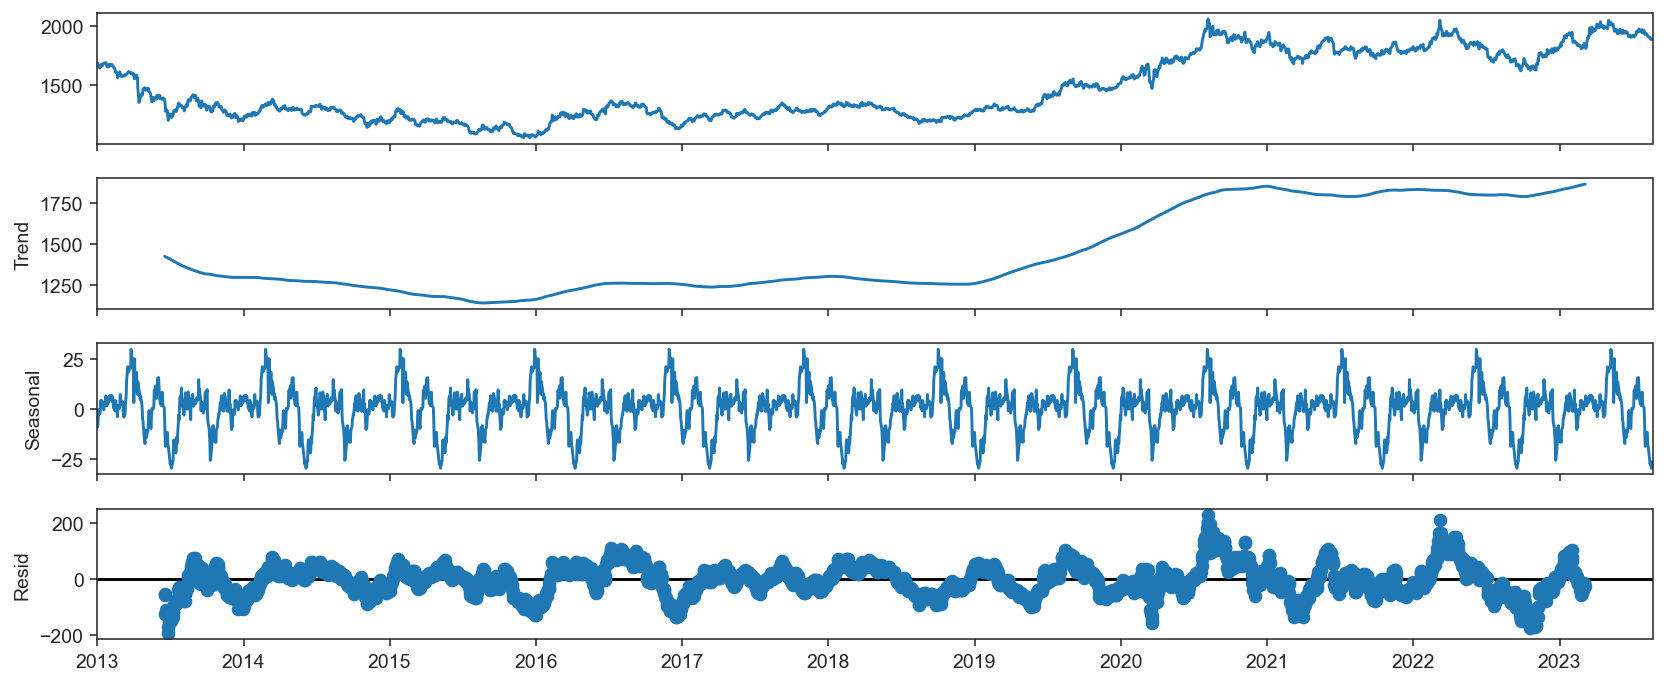

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
# Add ; in the end to only show one graph
add.plot();

Trend Plot :
- Overall trend decreased then increased. 

Seasonal plot :
- The variation of seasonal component looks constant. 

Residual plot :
- Residuals look larger after 2020, meaning multiplicative model might be more appropriate for our data.

In [30]:
mul = seasonal_decompose(tdf,model = 'mul',period=240)

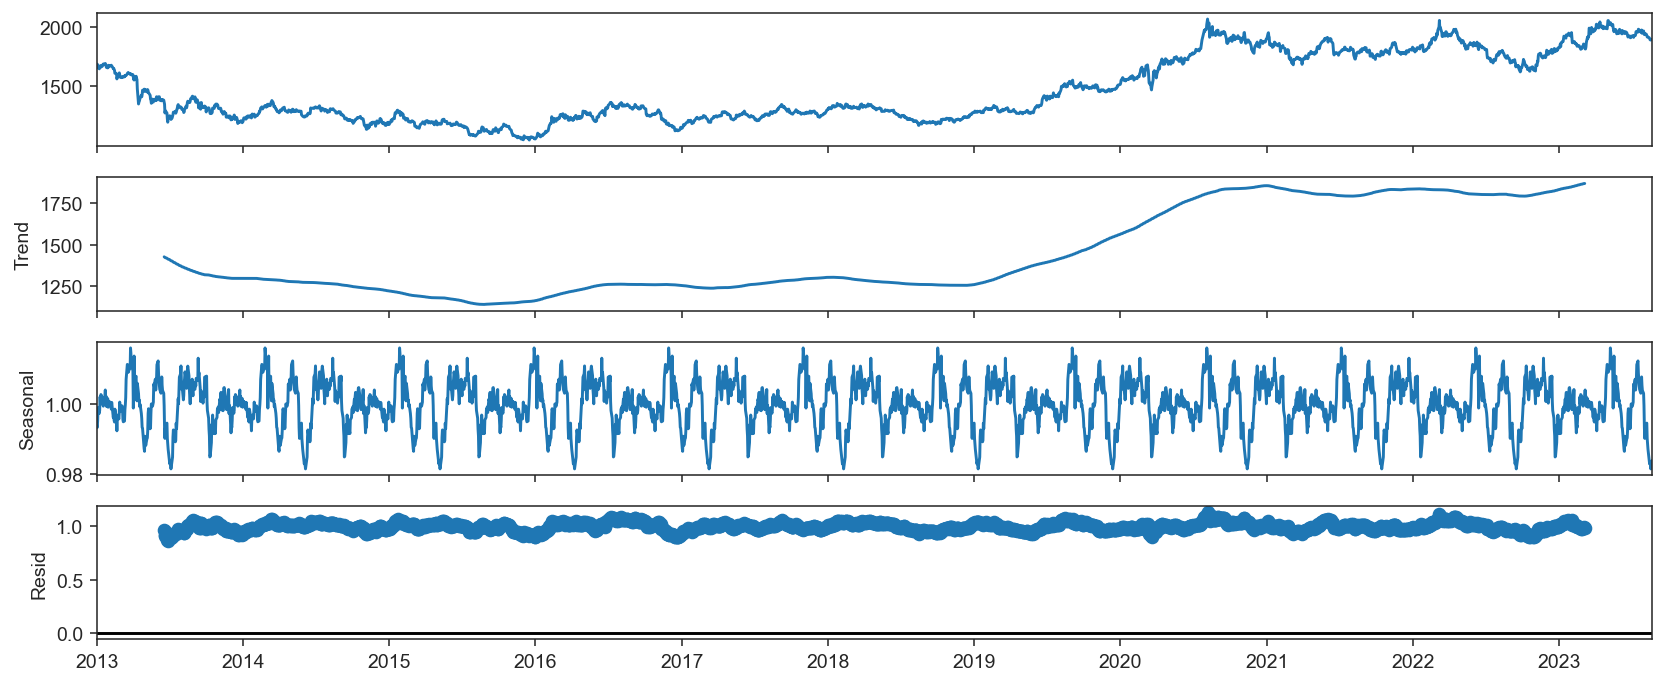

In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
# Add ; to only show one graph
mul.plot();

Now the residauls have constant variance. 

A Visual Guide to Time Series Decomposition Analysis :

https://www.encora.com/insights/a-visual-guide-to-time-series-decomposition-analysis

## EDA and Time Series Graphics
**The result shows there is trend but no/little seasonality in our data**.


#### Parameters for trend
- Monthly trend : MA(20)
- Quarterly trend : MA(60)
- Semiannual trend : MA(120)
- Annual trend : MA(240)

**We can see our data doesn't have constant mean over different periods, meaning there's trends in the data**

In [32]:
def moving_average(tdf,parameter):
     
    mov = tdf['XAU'].rolling(window=parameter).mean().dropna()
    
    plt.rcParams["figure.dpi"] = 140
    sns.set_style('ticks')
    ax = tdf['XAU'].plot.line(figsize=(12,5),title = f'XAU Daily Price & MA{parameter}')
    ax.autoscale(axis='x',tight=True)
    ax.legend(loc=2)
    mov.plot();

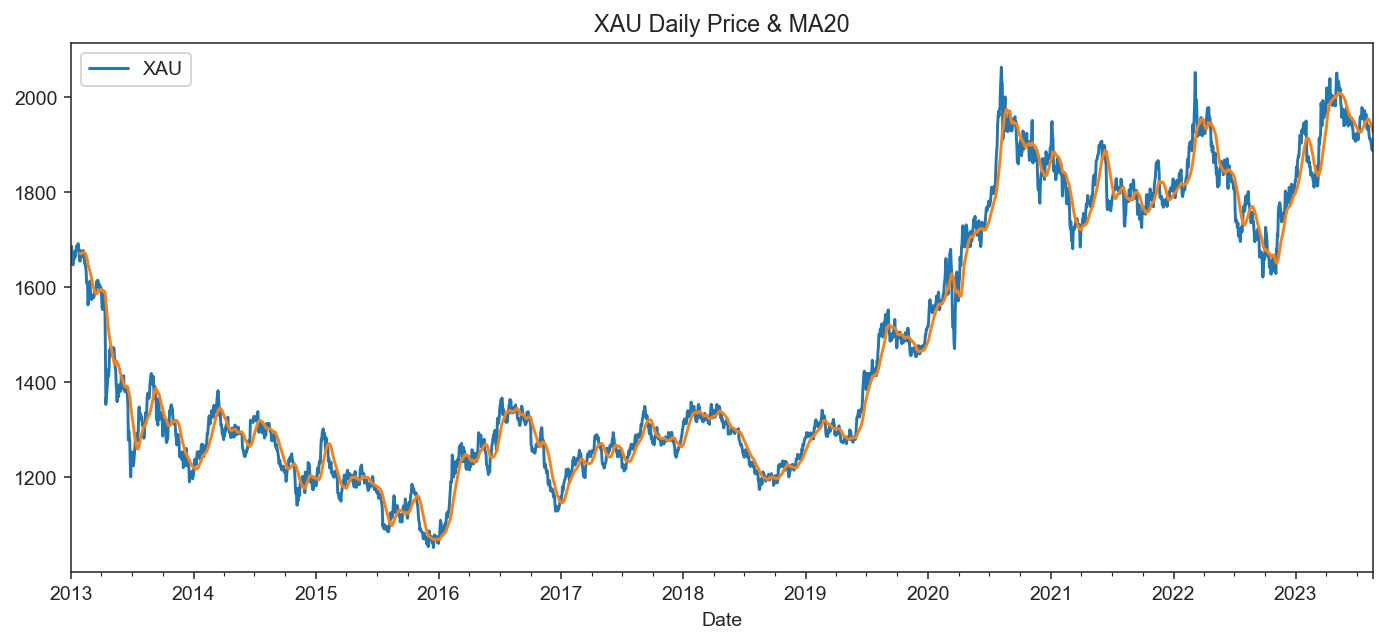

In [33]:
moving_average(tdf,20)

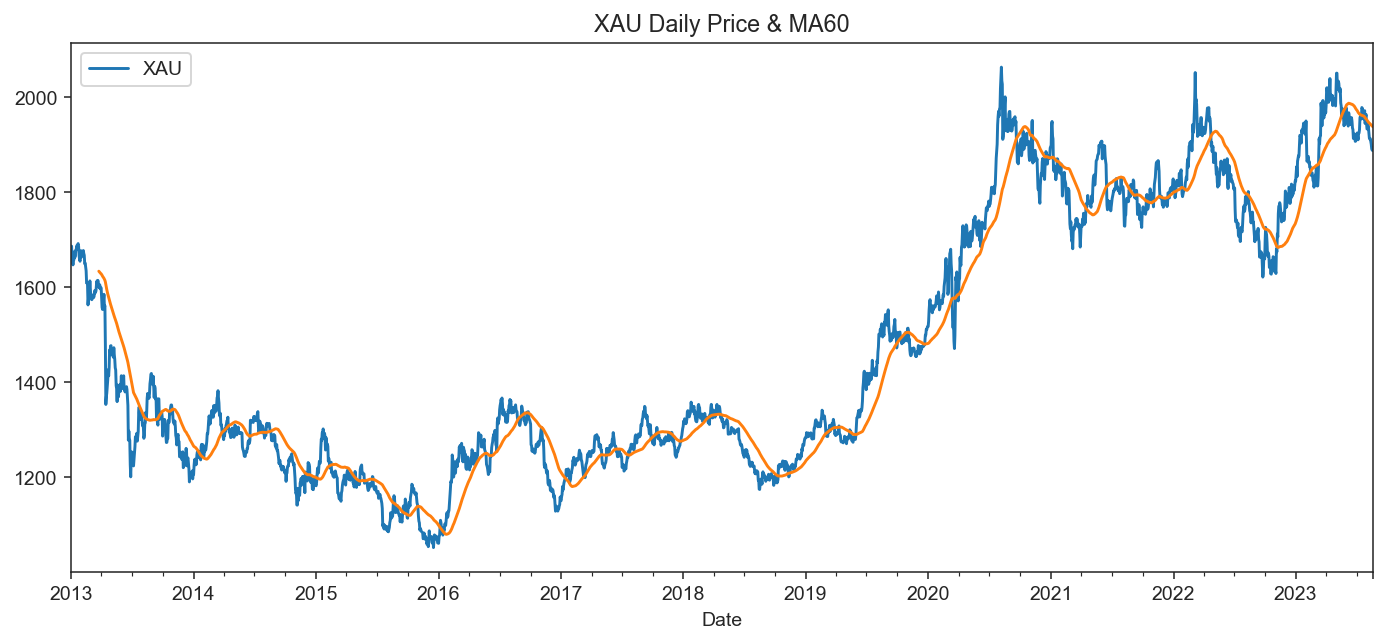

In [34]:
moving_average(tdf,60)

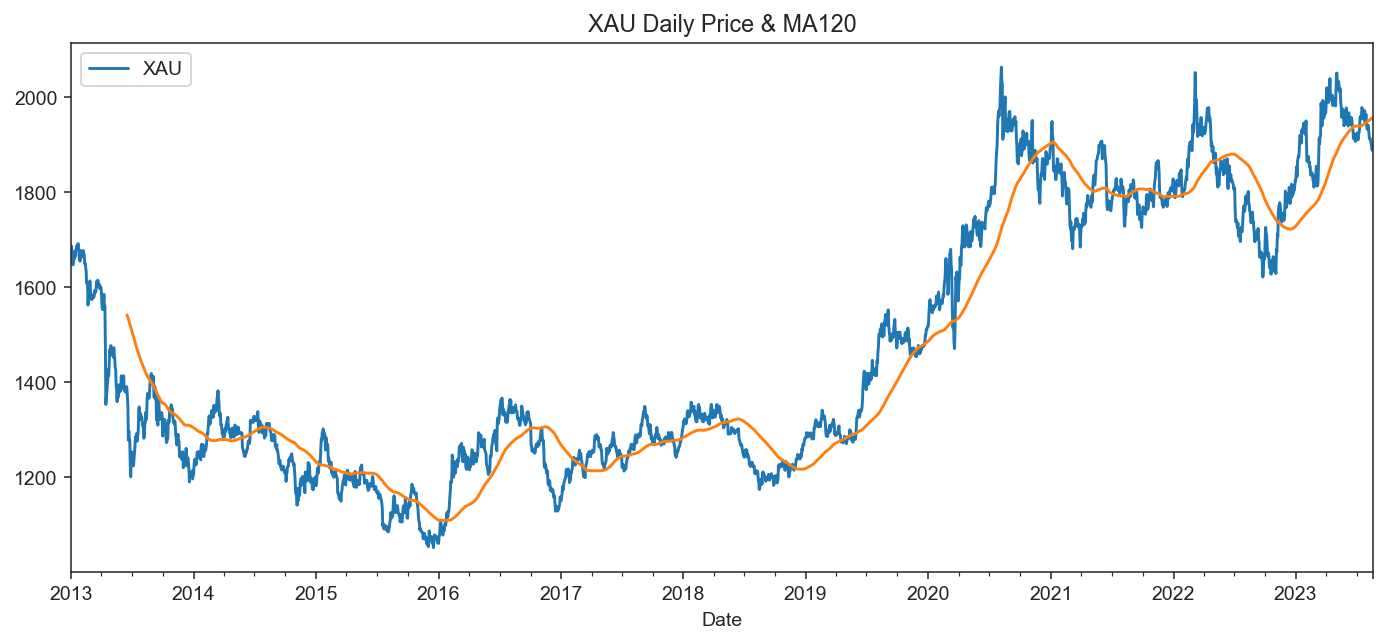

In [35]:
moving_average(tdf,120)

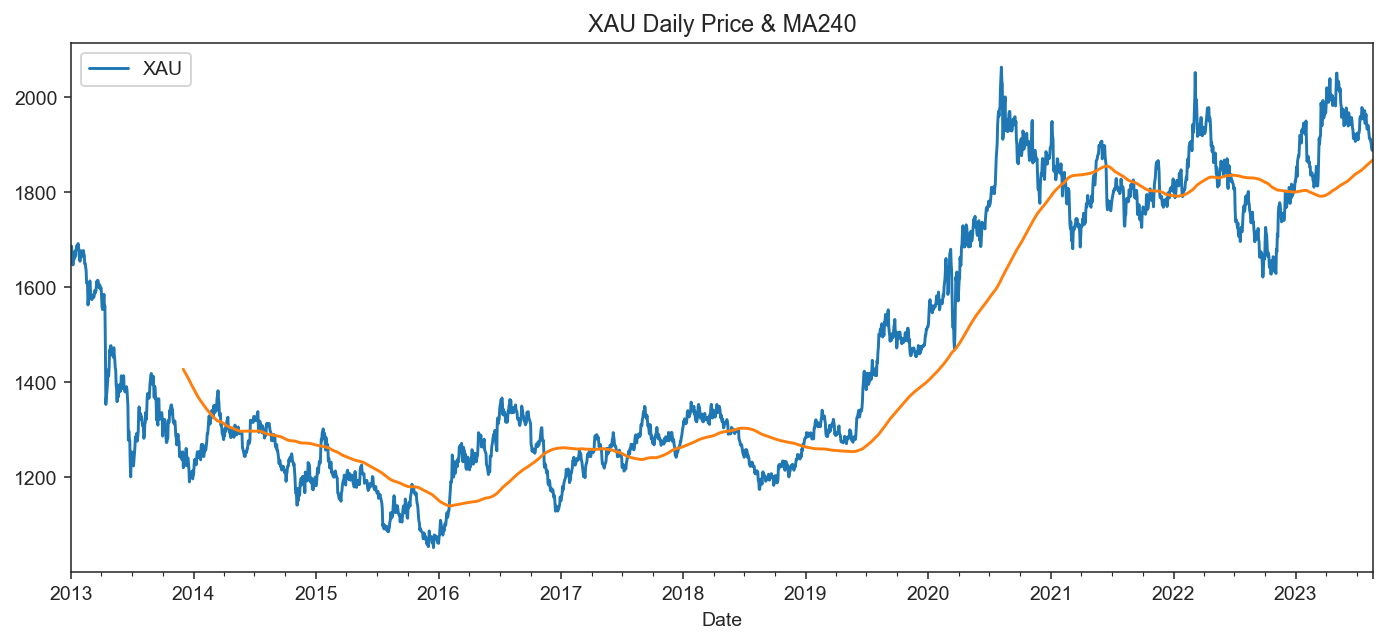

In [36]:
moving_average(tdf,240)

### Manual Seasonal Subseries Plots

In [37]:
# Create a month column
tdf['extract_m'] = tdf.index.month
tdf.head()

,XAU,extract_m
Date,,
2013-01-01,1675.15,1
2013-01-02,1686.75,1
2013-01-03,1663.35,1
2013-01-04,1656.85,1
2013-01-07,1647.25,1


In [38]:
# Change time formatting
tdf['Month'] = tdf.index.strftime('%B')
tdf.head()

,XAU,extract_m,Month
Date,,,
2013-01-01,1675.15,1,January
2013-01-02,1686.75,1,January
2013-01-03,1663.35,1,January
2013-01-04,1656.85,1,January
2013-01-07,1647.25,1,January


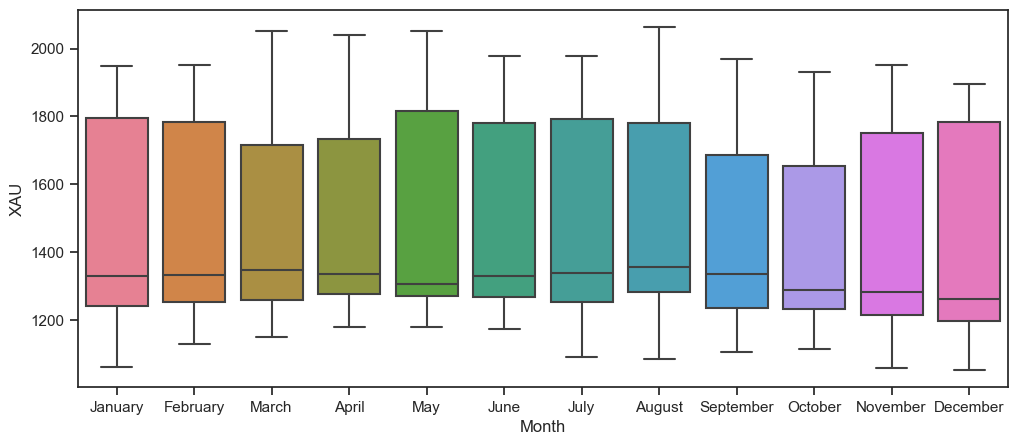

In [39]:
# Create a boxplot that groups by the Month field
# we can see that season 4 (Oct - Dec) tend to have lower values 
# Other than that, seasonality is not strong in this data
sns.set(rc={'figure.figsize':(12,5)})
sns.set(rc={'figure.dpi':100})
sns.set_style('ticks')
sns.boxplot(x='Month',y='XAU',data=tdf,palette='husl');

In [40]:
def quarter(month):
    if month in [1,2,3]:
        return 'Q1'
    elif month in [4,5,6]:
        return 'Q2'
    elif month in [7,8,9]:
        return 'Q3'
    else :
        return 'Q4'                          

In [41]:
tdf['Quarter'] = tdf['extract_m'].apply(quarter)
tdf

,XAU,extract_m,Month,Quarter
Date,,,,
2013-01-01,1675.15,1,January,Q1
2013-01-02,1686.75,1,January,Q1
2013-01-03,1663.35,1,January,Q1
2013-01-04,1656.85,1,January,Q1
2013-01-07,1647.25,1,January,Q1
...,...,...,...,...
2023-08-15,1901.56,8,August,Q3
2023-08-16,1891.76,8,August,Q3
2023-08-17,1888.89,8,August,Q3


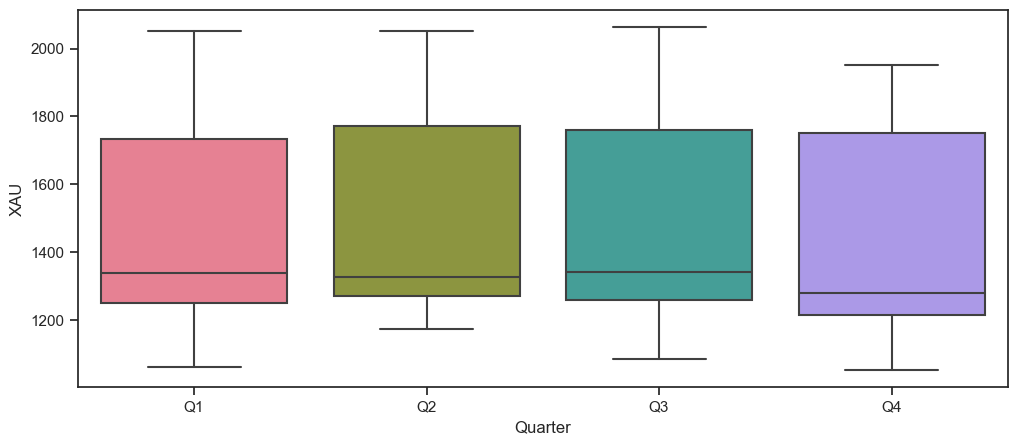

In [42]:
# Create a boxplot that groups by the Month field
# we can see that Q4 tend to have lower values(similar trend as above)
# Q1 - Q3 have similar range and median
sns.set(rc={'figure.figsize':(12,5)})
sns.set(rc={'figure.dpi':100})
sns.set_style('ticks')
sns.boxplot(x='Quarter',y='XAU',data=tdf,palette='husl');

### Statsmodels Month Plot and Quarter Plot
This is just an alternative way to show the same plots as above by using built-in library. 

In [43]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

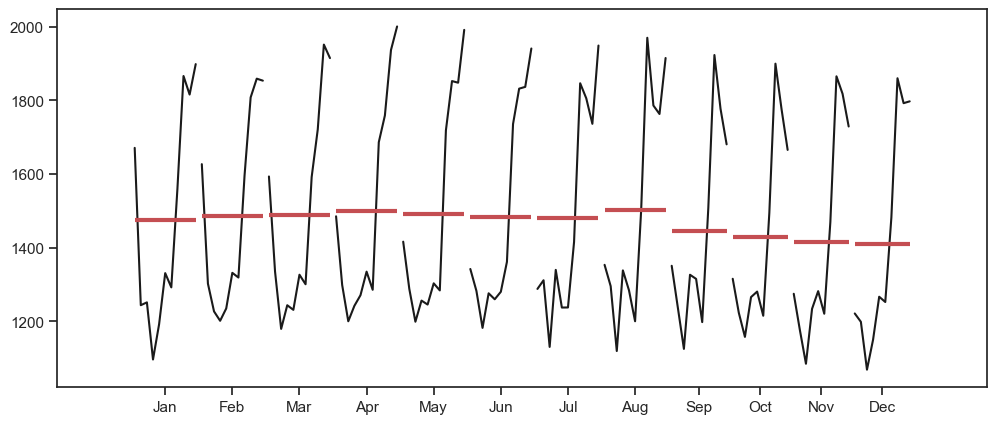

In [44]:
mdf = tdf['XAU'].resample(rule='MS').mean()
month_plot(mdf);

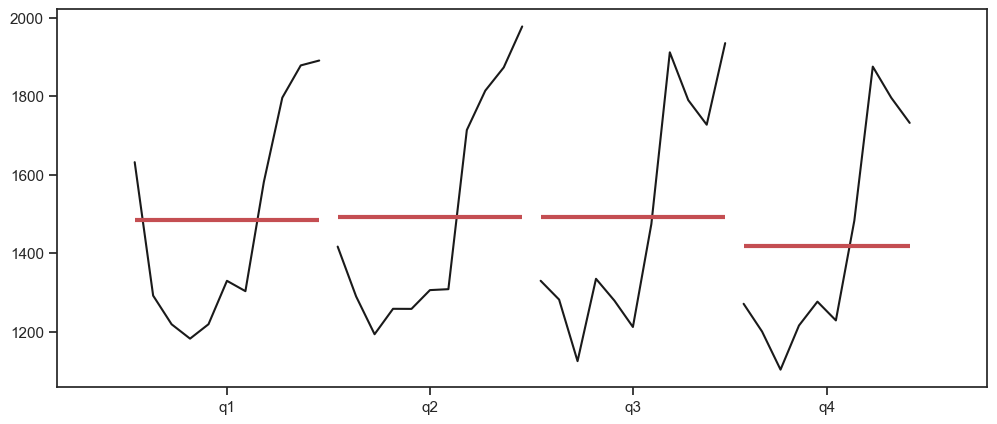

In [45]:
qdf = tdf['XAU'].resample(rule='Q').mean()
quarter_plot(qdf);

### Seasonal Plots

In [46]:
# Reset tdf to only include XAU values
tdf = tdf['XAU'].to_frame()

In [47]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,5))
    plt.legend(["2013", "2014", "2015", "2016", "2017","2018", "2019", "2020", "2021", "2022","2023"], bbox_to_anchor=(-0.1, 0.8), title='Year')
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    plt.xlabel("Month")

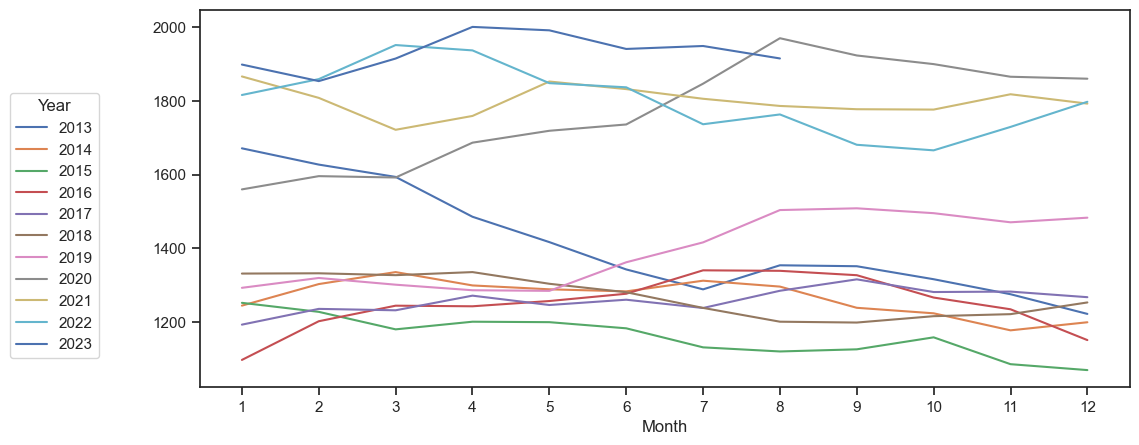

In [48]:
# Doens't seems to have certain seasonal patterns
# We can see more recent years have higher values (1600-2000)
seasonal_plot(tdf)

From month plot and quarter plot, we can see Q4 had lower median in general, but there's no  clear pattern of seasonality in XAU price.  

### Lag plot, ACF, and PACF
- ACF plot : an autocorrelation plot(Correlogram)shows that correlation of the series with itself, lagged by x time units. So, the y-axis is the correlation and the x-axis is the number of time unites of lag. Normally, there will be a gradual decline in the data. 
- PACF plot : gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. 

The ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. The PACF only describes the direct relaitonship between an observation and its lag. In addition, the blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically different than zero. 

These two plots can help choose order parameters for ARIMA based models. You can also use grid search to choose order parameters. 

Serial Correlation in Time Series Analysis : https://www.quantstart.com/articles/Serial-Correlation-in-Time-Series-Analysis/

https://www.r-bloggers.com/2022/11/autocorrelation-and-partial-autocorrelation-in-time-series/

In [49]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from pandas.plotting import lag_plot

In [50]:
import warnings
warnings.filterwarnings("ignore")

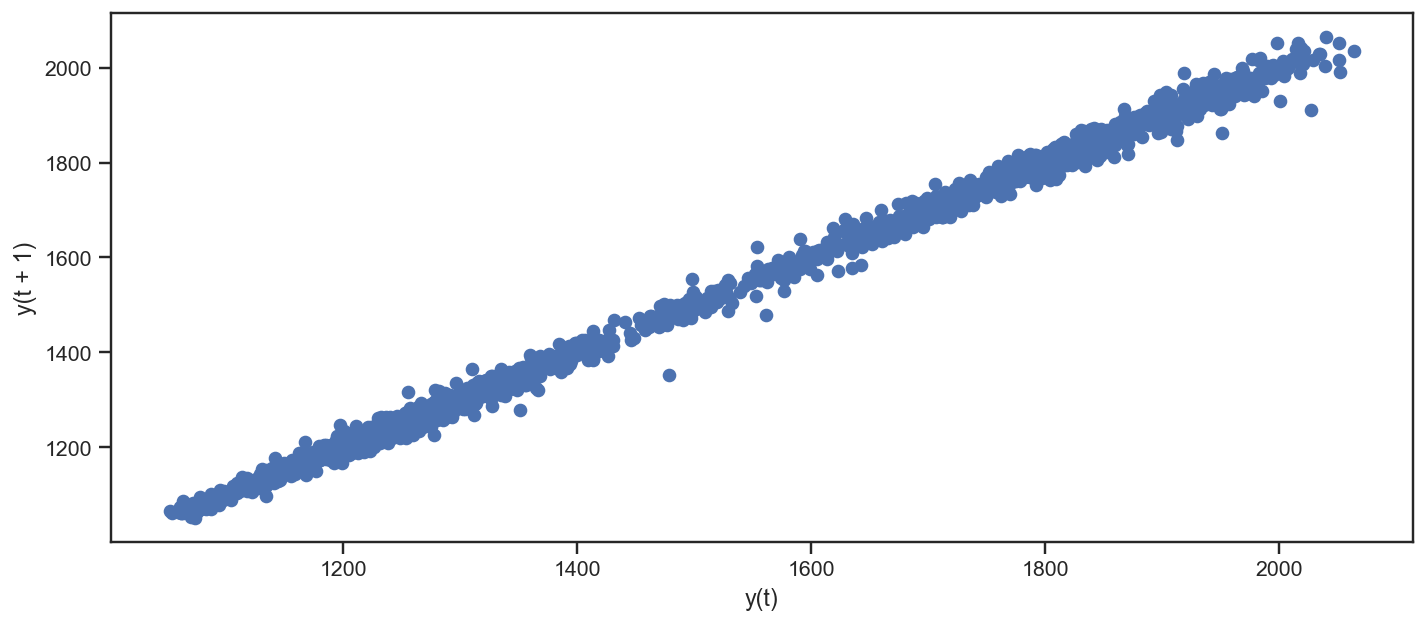

In [51]:
# Lag plot
plt.rcParams["figure.dpi"] = 140
fig, ax = plt.subplots(figsize=(12,5)) 
lag_plot(tdf);

Visually shows evidence of a very strong autocorrelation between y(t) and its lag in this data

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [53]:
# ACF arrays with 40 lags
acf(tdf['XAU'])

array([1.        , 0.99817451, 0.99630897, 0.99455737, 0.99275071,
       0.99098448, 0.98923081, 0.98748776, 0.98575498, 0.98396665,
       0.98215168, 0.98040426, 0.97868186, 0.97693158, 0.97509865,
       0.97318882, 0.97130172, 0.96945999, 0.96777546, 0.96613409,
       0.96449078, 0.96294427, 0.96141671, 0.959851  , 0.95830328,
       0.95669959, 0.95513882, 0.95360915, 0.95208345, 0.95046551,
       0.94888674, 0.94726294, 0.94566866, 0.94408754, 0.94243229])

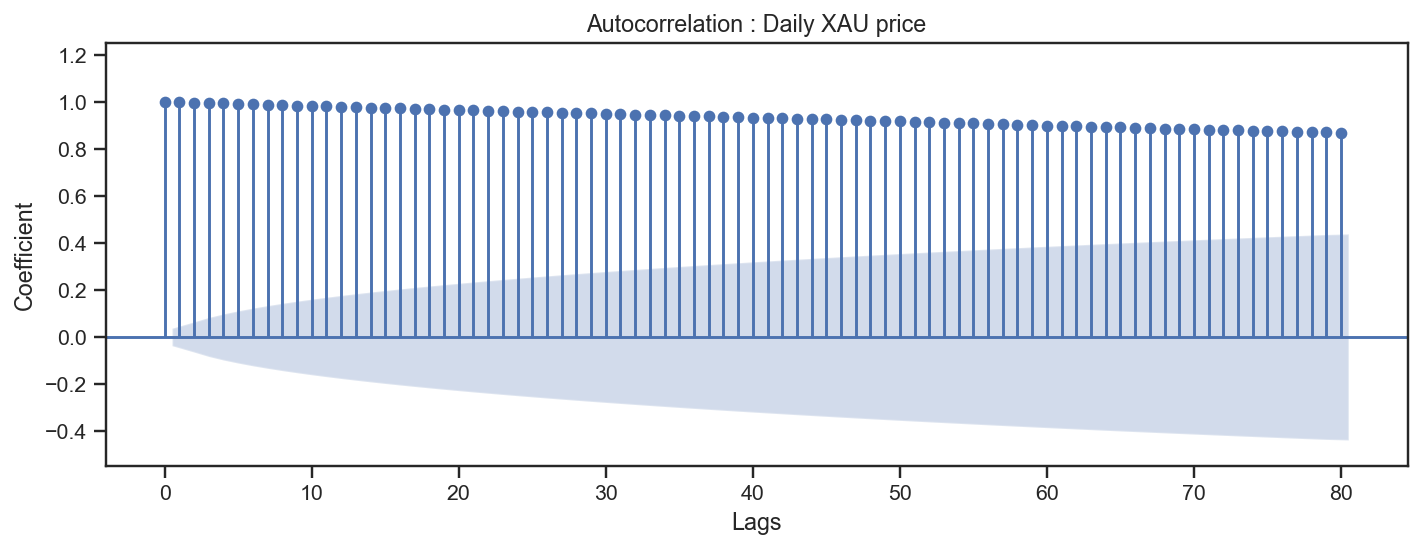

In [54]:
# ACF plot with 80 lags
# This plot indicates non-stationary data
# Gradual decline indicates that there is trend in our data
# Doesn't show seasonality as well
title = 'Autocorrelation : Daily XAU price'
lags = 80
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(tdf,title=title,lags=lags,auto_ylims=True,ax=ax)
plt.xlabel("Lags")
plt.ylabel("Coefficient");

There is significant autocorrelation in this plot. Also, the gradual decline of positive values could mean our data is trended time series and is non-stationary(ACF plot of stationary data will drop to zero relatively quickly). In addition, there is no seasonality showing in this plot (no periodic peaks). 

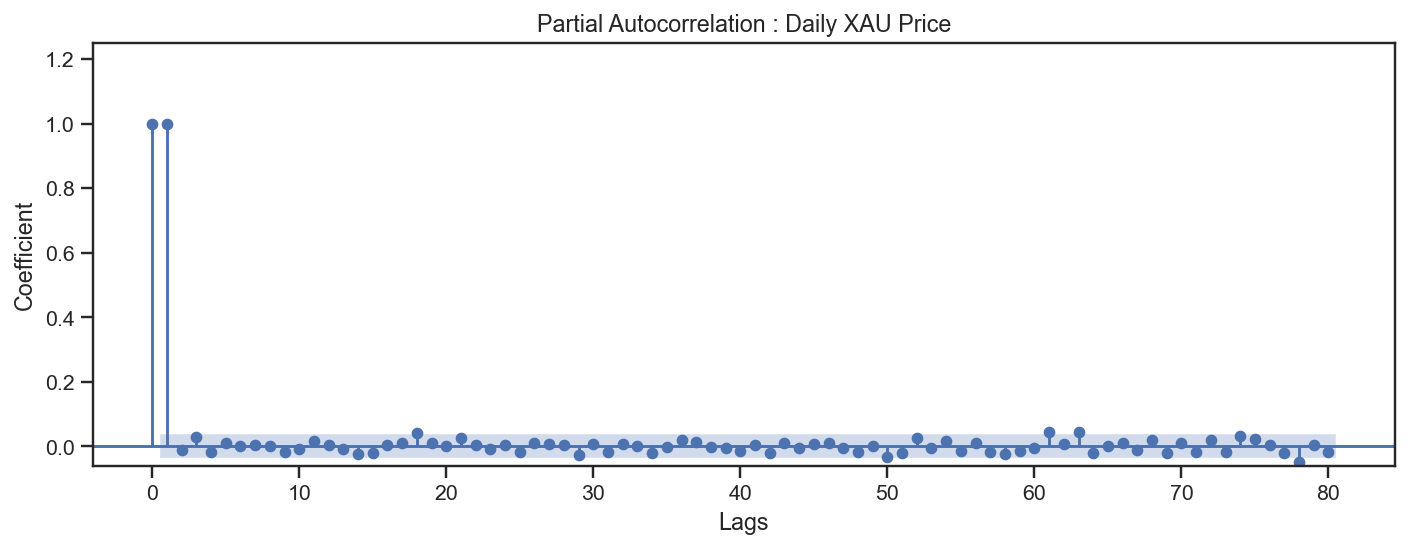

In [55]:
# PACF with 80 lags
# Sharp drop after 1
title = 'Partial Autocorrelation : Daily XAU Price'
lags =80
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(tdf,title=title,lags=lags,auto_ylims=True,ax=ax)
plt.xlabel("Lags")
plt.ylabel("Coefficient");

There is a strong positive autocorrelation with lag 1.

From ACF and PACF above, AR model is prefered. However, we will still use grid search for the best parameters. 

## Stationarity and Augmented Dickey-Fuller Test 
Stationary data is data that does not exhibit trends or seasonality. It is also a series of values that are not a function of time. It means that fluctuations in the data are entirely due to outside forces and noise. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time. In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal(although some cyclic behaviour is possible), with constant variance. 

We already know the the mean of our data is not constant, meaning the data is non-stationary. However, we still use Dickey-Fuller test here. 

**The test result shows that our data is non-stationary.**

#### Why does stationarity matter in time series analysis?

stationarity is important because, in its absence, a model describing the data will vary in accuracy at different time points. As such, stationarity is required for sample statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.

In [56]:
from statsmodels.tsa.stattools import adfuller

In [57]:
# Pass in a time series and an optional title, returns an ADF report
def adf_test(series,title=''):
    
    print(f"Augmented Dickey-Fuller Test : {title}")
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    # the fifth result(form : dictionary) is critical value 1%-10%
    for key,val in result[4].items():
          # create a row in Series
          out[f'critical value ({key})'] = val
    
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())
          
    # result[1] is p-value
          
    if result[1] <=0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
          

In [58]:
# We know our data is non-stationary
# This means if we want to use machine learning model, we need to make our data stationary
adf_test(tdf)

Augmented Dickey-Fuller Test : 
ADF test statistic        -0.949282
p-value                    0.771311
# lags used                2.000000
# observations          2772.000000
critical value (1%)       -3.432711
critical value (5%)       -2.862583
critical value (10%)      -2.567325
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


### Differencing
Non-stationary data can be made to look stationary through differencing. Differencing computes the differences between consecutive observations. It can help stabilize the mean of a time series by removing changes in the level of a time series, and therefore eliminating(or reducing) trend and seasonality. ACF plot is useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 

In [59]:
from statsmodels.tsa.statespace.tools import diff

In [60]:
# First order differencing
# Each differencing step will lose one row of data
tdf['diff'] = diff(tdf['XAU'],k_diff=1)
tdf

,XAU,diff
Date,,
2013-01-01,1675.15,NaN
2013-01-02,1686.75,11.60
2013-01-03,1663.35,-23.40
2013-01-04,1656.85,-6.50
2013-01-07,1647.25,-9.60
...,...,...
2023-08-15,1901.56,-6.34
2023-08-16,1891.76,-9.80
2023-08-17,1888.89,-2.87


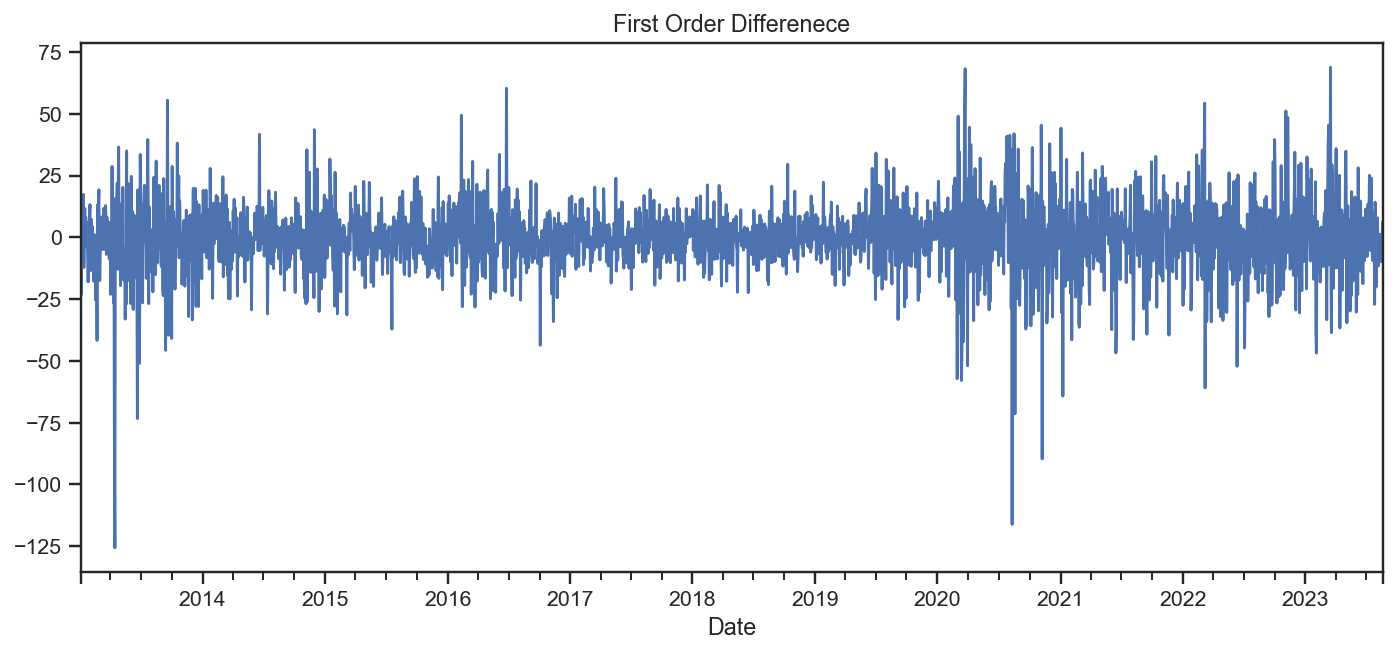

In [61]:
tdf['diff'].plot(title="First Order Differenece").autoscale(axis='x',tight=True)

In [62]:
# After first order differencing, our data became stationary
adf_test(tdf['diff'])

Augmented Dickey-Fuller Test : 
ADF test statistic       -38.268940
p-value                    0.000000
# lags used                1.000000
# observations          2772.000000
critical value (1%)       -3.432711
critical value (5%)       -2.862583
critical value (10%)      -2.567325
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is stationary


In [63]:
# Drop the first row with NaN value
f_diff = tdf['diff'].dropna().to_frame()
f_diff

,diff
Date,
2013-01-02,11.60
2013-01-03,-23.40
2013-01-04,-6.50
2013-01-07,-9.60
2013-01-08,11.75
...,...
2023-08-15,-6.34
2023-08-16,-9.80
2023-08-17,-2.87


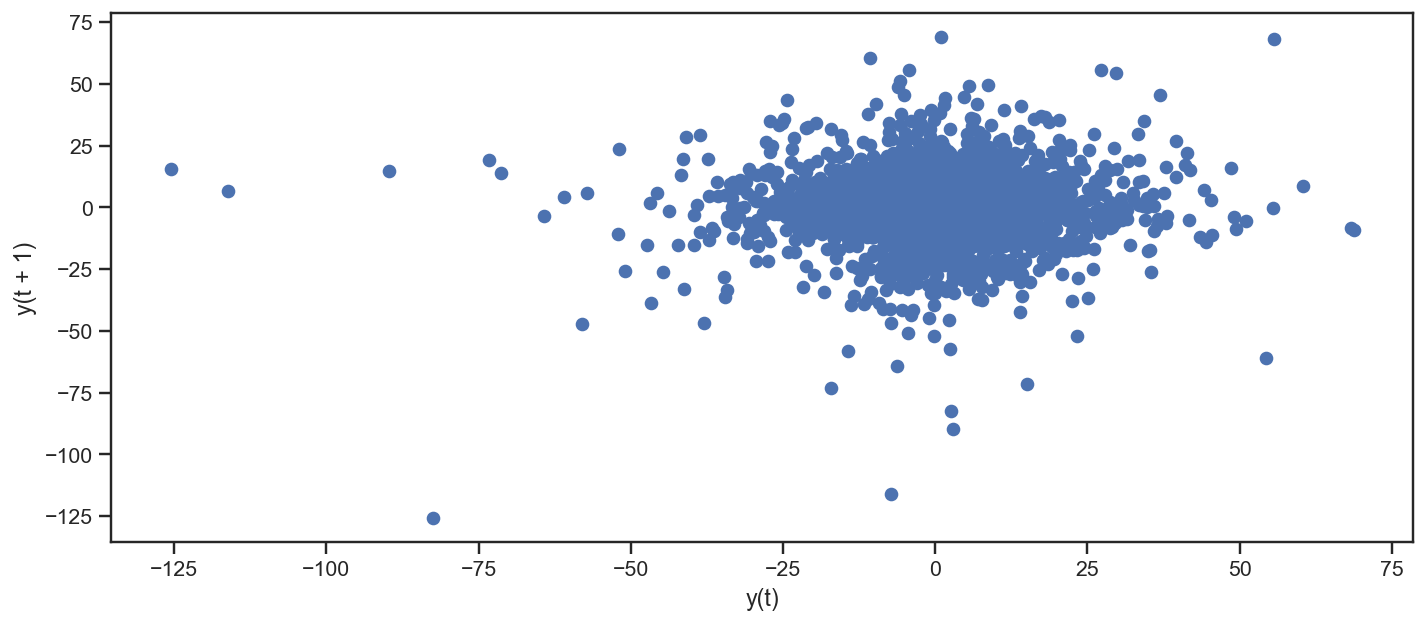

In [64]:
# Lag plot
# There is little evidence of autocorrelation after 1st order differencing
plt.rcParams["figure.dpi"] = 140
fig, ax = plt.subplots(figsize=(12,5)) 
lag_plot(f_diff);

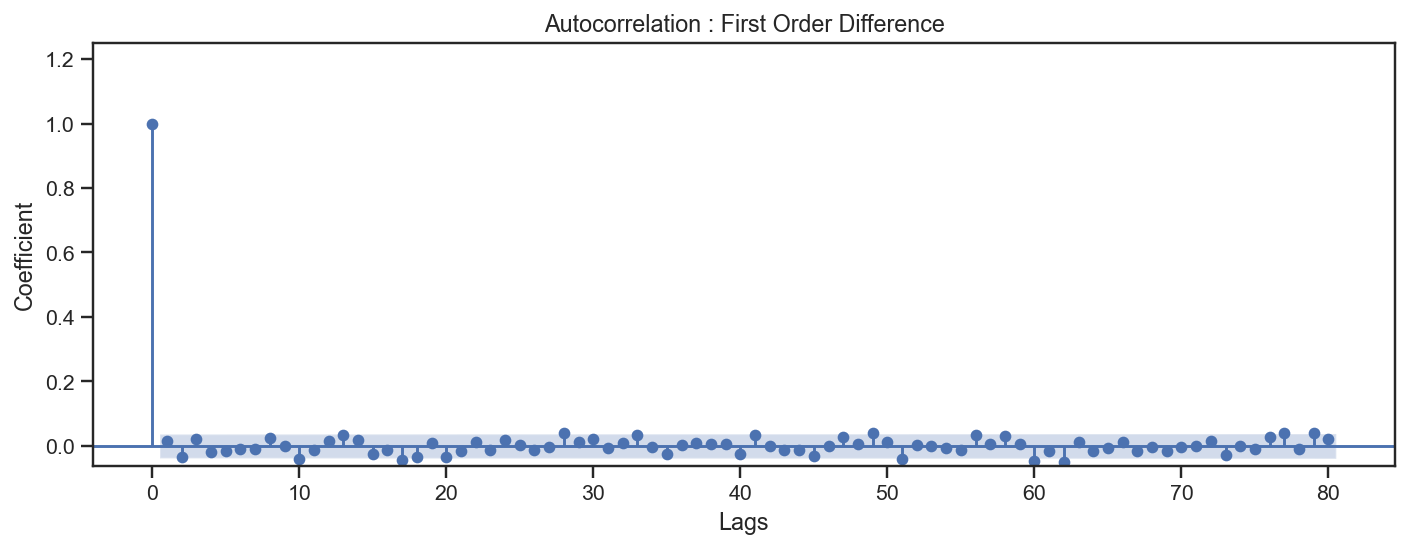

In [65]:
# ACF plot with 80 lags
# Sharp drop
title = 'Autocorrelation : First Order Difference'
lags = 80
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(f_diff,title=title,lags=lags,auto_ylims=True,ax=ax)
plt.xlabel("Lags")
plt.ylabel("Coefficient");

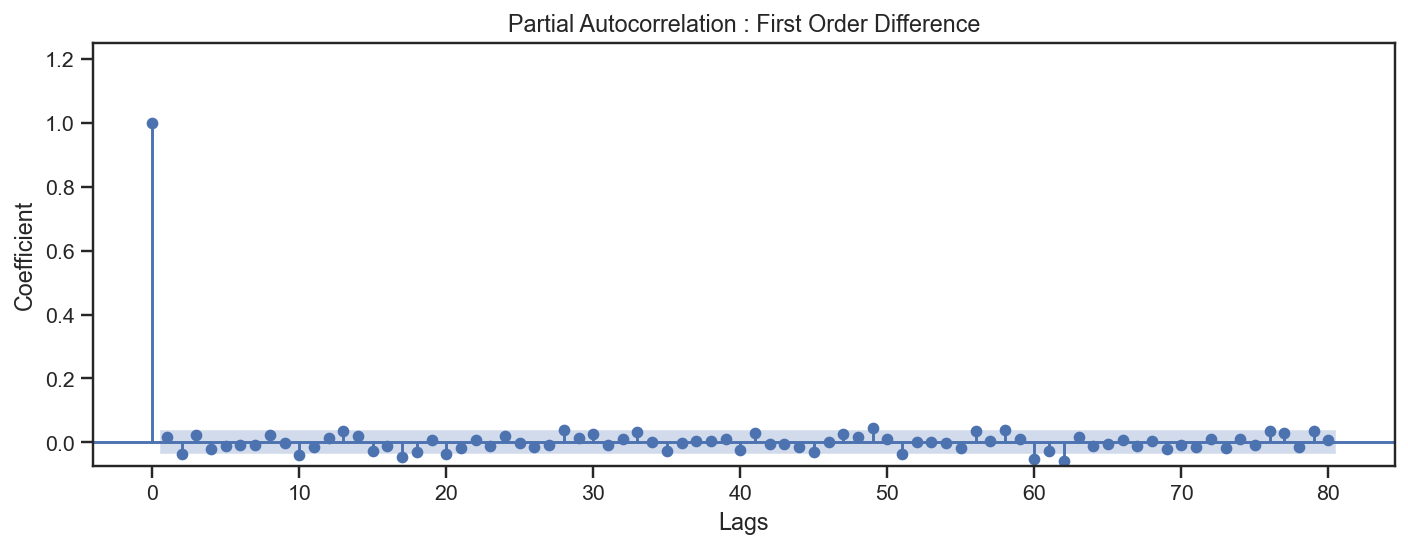

In [66]:
# PACF with 80 lags
# Sharp drop 
title = 'Partial Autocorrelation : First Order Difference'
lags =80
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(f_diff,title=title,lags=lags,auto_ylims=True,ax=ax)
plt.xlabel("Lags")
plt.ylabel("Coefficient");

The ACF plot of differenced XAU daily price looks just like that of a white noise series. There is no significant autocorrelation to any lag(no autocorrelations lying outside the 95% confidence levels), suggesting the daily change in XAU price is essentially a random series which is uncorrelated with the change of previous days. 

Rearranging white noise formula leads to the "random walk" model. which is widely used for financial and economic data.   Random walk model typically have long periods of apparent trend up or down and sudden and unpredictable changes in direction.  

Since we have established that our time series is a random walk, we cannot use any statistical methods to estimate the randomness. A random walk is upredictable. We can expect the best prediction method is to use the previous observation for the next time step. If we have to forecast, we will have to use naive methods - Last known value, mean, drifting values etc.

**More details on random walk :**

https://www.youtube.com/watch?v=PSpb7rJWXww&ab_channel=DataSciencewithMarco
https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/


A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence. That is, the current observation is a random step from the previous observation.Therefore, we can expect a random walk to be non-stationary. Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.


### Original Series and Differenced Data Overview

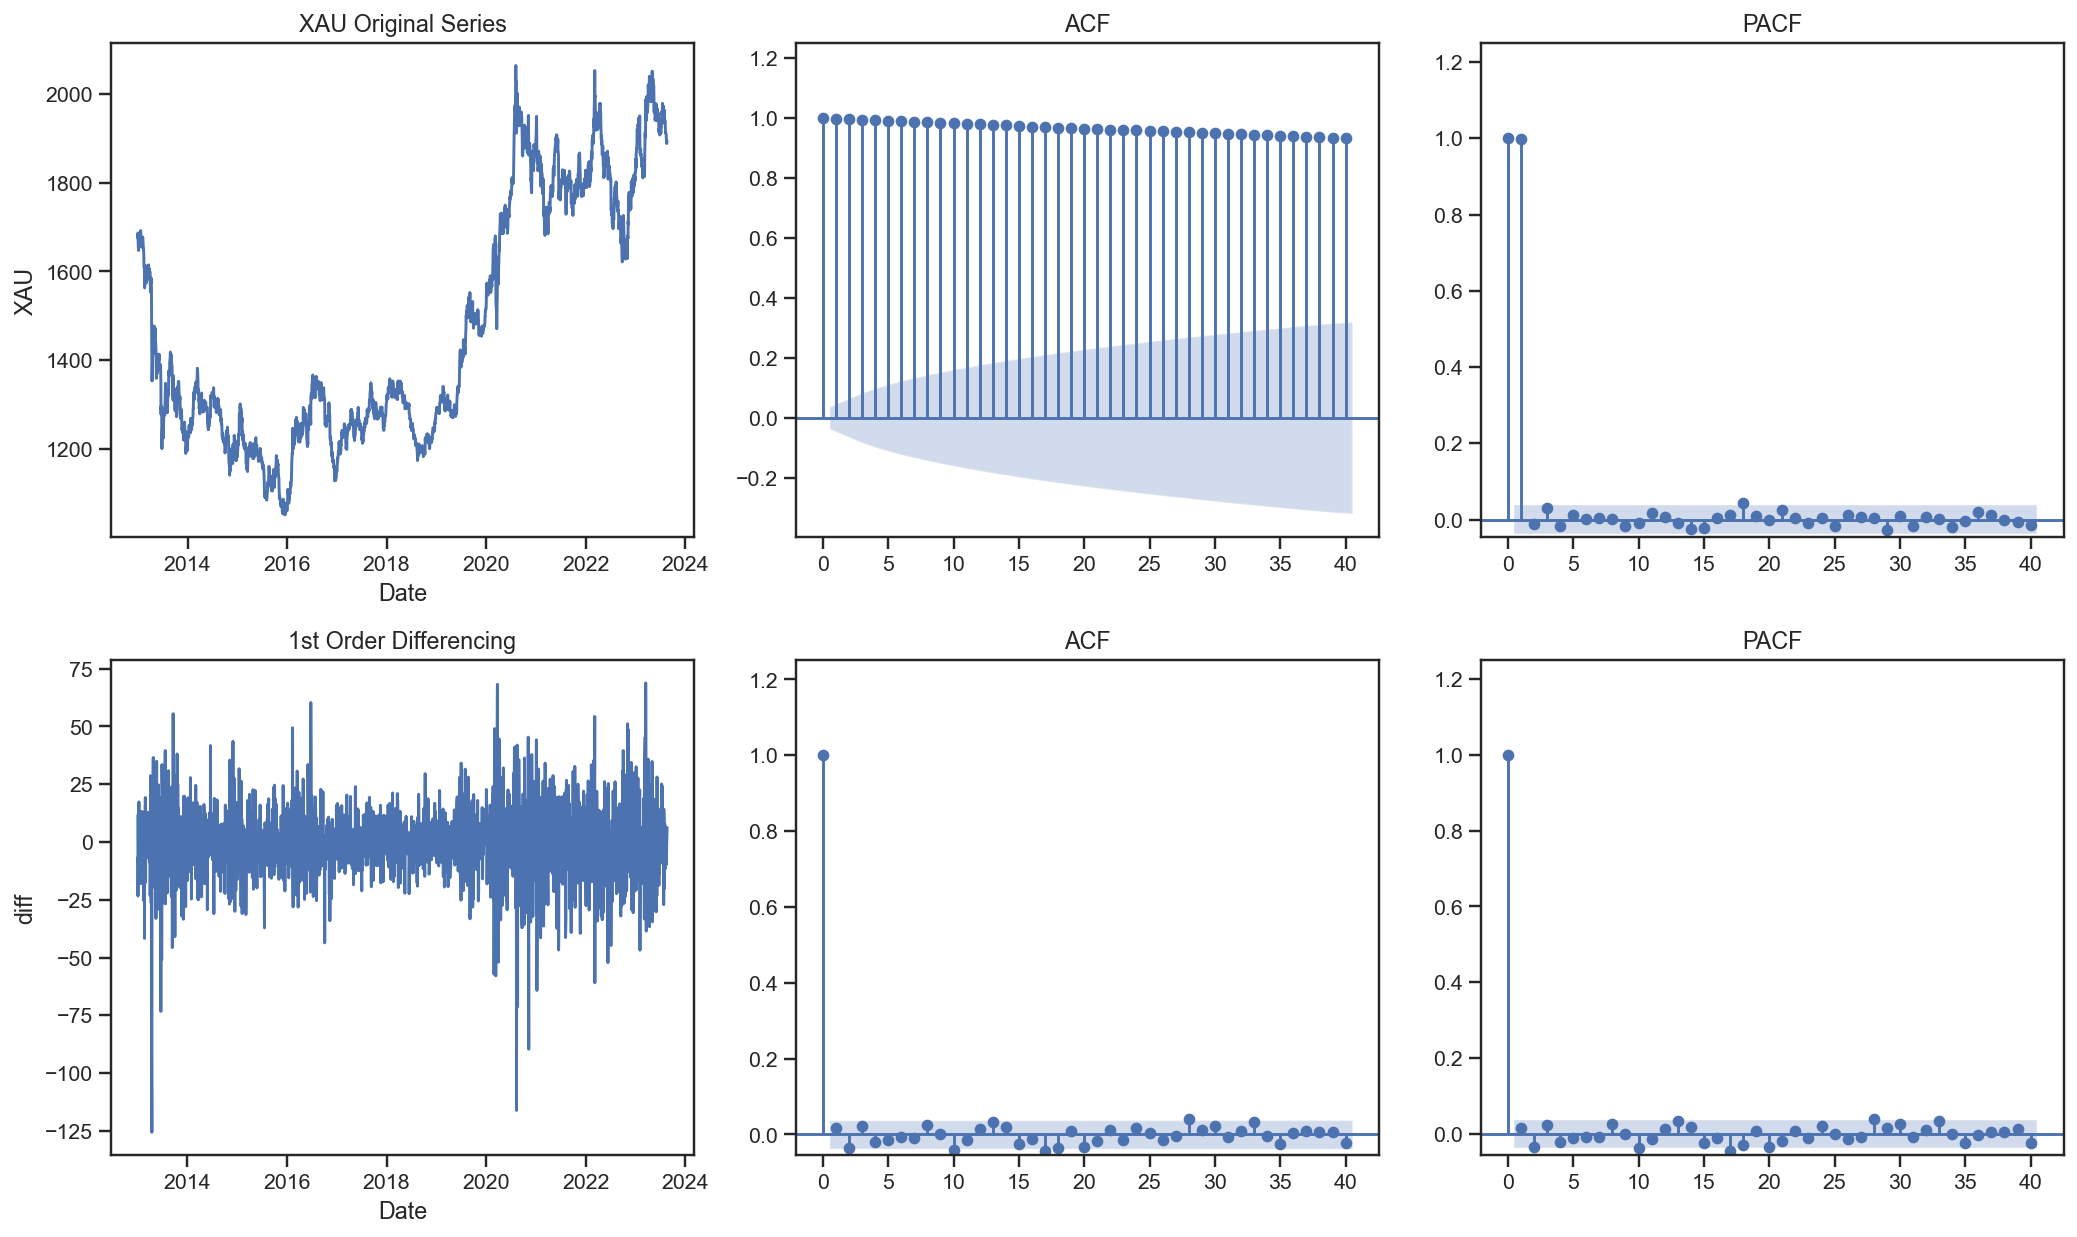

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
sns.lineplot(y='XAU', x='Date', data=tdf, ax=axes[0,0]).set_title("XAU Original Series");
plot_acf(tdf['XAU'], lags=40, ax=axes[0, 1],title='ACF',auto_ylims=True)
plot_pacf(tdf['XAU'], lags=40, ax=axes[0, 2],title='PACF',auto_ylims=True)

sns.lineplot(y='diff', x='Date', data=f_diff, ax=axes[1,0]).set_title("1st Order Differencing");
plot_acf(f_diff, lags=40, ax=axes[1, 1],title='ACF',auto_ylims=True)
plot_pacf(f_diff, lags=40, ax=axes[1, 2],title='PACF',auto_ylims=True)

plt.tight_layout()
plt.show();

## Model Selection

Although we already know our data is random walk/white noise, Exponential Smoothing model, ARIMA model, Facebook prophet library, and LSTM(deep learning) model are still applied here as practices. 
### ARIMA Models, Fundamental Analysis, Technical Analysis, & Random Walk 
Stock price data has so many outside factors that much of the information informing the price of the stock won't be available with just the time stamped price information. **ARIMA performs very well when working with a time series where the data is directly related to the time stamp**,but it won't be able to understand any outide factors that is already presented in the current data. This means ARIMA model might not be an ideal model to predict future stock price. 

Fundamental analysis is a method of evaluating securities by attempting to measure the intrinsic value of a stock. Fundamental analysts study everything from the overall economy and industry conditions to the financial condition and management of companies. Earnings, expenses, assets, and liabilities are all important characteristics to fundamental analysts.

Technical analysis differs from fundamental analysis in that the stock's price and volume are the only inputs. The core assumption of Technical Analysis in trading is that **all known fundamentals are factored into price**; thus, there is no need to pay close attention to them. Technical analysts do not attempt to measure a security's intrinsic value, but instead, use stock charts to identify patterns and trends that suggest what a stock will do in the future.

Technical analysis has three main principles and assumptions: (1) The market discounts everything, (2) prices move in trends and countertrends, and (3) price action is repetitive, with certain patterns reoccurring.

Random walk theory suggests that changes in asset prices are random. This means that stock prices move unpredictably, **so that past prices cannot be used to accurately predict future prices.** Random walk theory also implies that the stock market is efficient and reflects all available information.Random walk theory considers fundamental analysis undependable due to the often-poor quality of information collected and its ability to be misinterpreted.

Global Univariate models (SARIMAX, Tree-Based Methods, MLP, CNN, RNN/LSTM)

**Resources :**
1. Random Walk Theory : 
https://www.investopedia.com/terms/r/randomwalktheory.asp


2. Technical Analysis :
https://www.cfainstitute.org/en/membership/professional-development/refresher-readings/technical-analysis#:~:text=Technical%20analysis%20has%20three%20main,repetitive%2C%20with%20certain%20patterns%20reoccurring.


3. Limitations of Technical Analysis : https://www.investopedia.com/terms/t/technicalanalysis.asp#:~:text=The%20core%20assumption%20is%20that,will%20do%20in%20the%20future.


4. White Noise and Random Walks in Time Series Analysis : https://www.quantstart.com/articles/White-Noise-and-Random-Walks-in-Time-Series-Analysis/#:~:text=A%20random%20walk%20is%20another,random%20step%20up%20or%20down.


5. Choosing the Best ML Time Series Model :
https://towardsdatascience.com/choosing-the-best-ml-time-series-model-for-your-data-664a7062f418


6. How to Select a Model For Your Time Series Prediction Task : https://neptune.ai/blog/select-model-for-time-series-prediction-task


### Data Preparation for ML Models
#### Train Test Split

In [68]:
# There are 2775 rows
tdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2775 entries, 2013-01-01 to 2023-08-21
Freq: B
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XAU     2775 non-null   float64
 1   diff    2774 non-null   float64
dtypes: float64(2)
memory usage: 129.6 KB


In [69]:
# Check the last date
tdf.tail(1)

,XAU,diff
Date,,
2023-08-21,1894.44,6.25


In [70]:
# We want to forecast to 2023-12-31
# 94 business days
fc_idx = pd.date_range("2023-08-22","2023-12-31",freq='B')
fc_idx.shape

(94,)

In [71]:
# Test sets will be the most recent 20% end of the data
# Test sets should be at least = maximum forecast 
# Here, we just use 94 days(equal to the forcast)
num = 2775-94
num

2681

In [72]:
train = tdf.iloc[:num]
test = tdf.iloc[num:]
train = train.drop("diff",axis=1)
test = test.drop("diff",axis=1)
print(f" X_train shape :{train.shape}")
print(f" X_test shape :{test.shape}")   

 X_train shape :(2681, 1)
 X_test shape :(94, 1)


In [73]:
# Check the end of data : forecast after 2023-08-21
test.tail()

,XAU
Date,
2023-08-15,1901.56
2023-08-16,1891.76
2023-08-17,1888.89
2023-08-18,1888.19
2023-08-21,1894.44


#### Evaluation Metrics Function

In [74]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import getpass

In [75]:
def eval_metric(data,test,preds):
    
    Mean = np.round(data['XAU'].dropna().mean(),2)
    MAE = np.round(mean_absolute_error(test['XAU'],preds),2)
    com_MAE = np.round(MAE/Mean*100,2)
    RMSE = np.round(np.sqrt(mean_squared_error(test['XAU'],preds)),2)
    com_RMSE = np.round(RMSE/Mean*100,2)
    
    
    print(f"Mean :{Mean}")
    print(f"MAE : {MAE}")
    print(f'Compare MAE with mean :{com_MAE}%')
    print(f"RMSE : {RMSE}")
    print(f'Compare RMSE with mean :{com_RMSE}%')

### Modeling and Forecasting

#### Double/Triple Exponential Smoothing
- Mean :1450.31
- MAE : 55.58
- Compare MAE with mean :3.83%
- RMSE : 64.6
- Compare RMSE with mean :4.45%

#### ARIMA Model (0,1,0)
- Mean :1450.31
- MAE : 50.15
- Compare MAE with mean :3.46%
- RMSE : 58.28
- Compare RMSE with mean :4.02%

#### Prophet
- Mean :1450.31
- MAE : 119.08
- Compare MAE with mean :8.21%
- RMSE : 124.19
- Compare RMSE with mean :8.56%

#### LSTM(Deep learning)
- Mean :1450.31
- MAE : 49.93
- Compare MAE with mean :3.44%
- RMSE : 58.03
- Compare RMSE with mean :4.0%

#### Naive Method (last value)
- Model's name : Naive_l
- Mean :1450.31
- MAE : 50.15
- Compare MAE with mean :3.46%
- RMSE : 58.28
- Compare RMSE with mean :4.02%


### Double/Triple Exponential Smoothing 

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [77]:
tdf['DESadd'] = ExponentialSmoothing(tdf['XAU'],trend='add').fit().fittedvalues.shift(-1)
tdf['DESmul'] = ExponentialSmoothing(tdf['XAU'],trend='mul').fit().fittedvalues.shift(-1)

In [78]:
tdf

,XAU,diff,DESadd,DESmul
Date,,,,
2013-01-01,1675.15,NaN,1675.130845,1675.125834
2013-01-02,1686.75,11.60,1686.703635,1686.691577
2013-01-03,1663.35,-23.40,1663.466054,1663.464120
2013-01-04,1656.85,-6.50,1656.873591,1656.879837
2013-01-07,1647.25,-9.60,1647.281254,1647.293982
...,...,...,...,...
2023-08-15,1901.56,-6.34,1901.827879,1901.640492
2023-08-16,1891.76,-9.80,1892.037523,1891.856584
2023-08-17,1888.89,-2.87,1889.128952,1888.951648


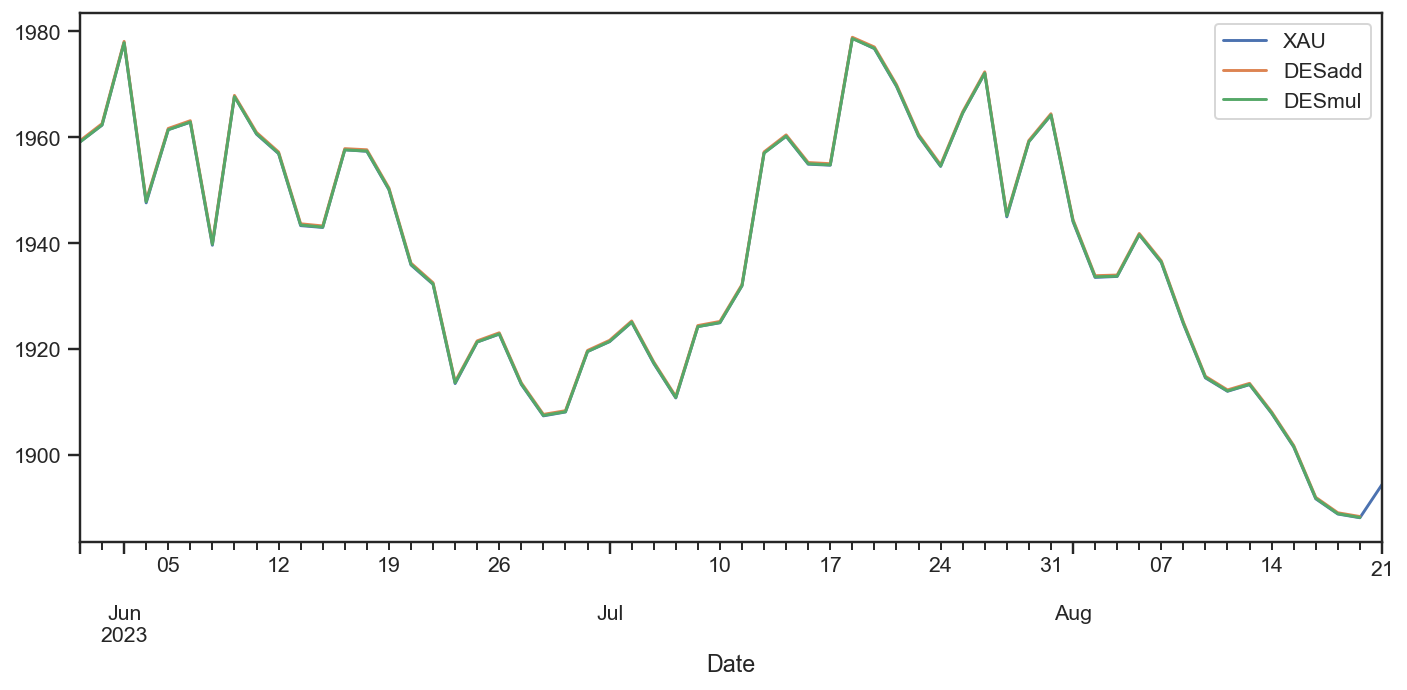

In [79]:
tdf[['XAU', 'DESadd', 'DESmul']].iloc[-60:].plot();

DESmul, DESadd, and XAU are overlapping. We can also see the values above. DESmul and DESadd don't have much difference. 

In [80]:
tdf['TESadd240'] = ExponentialSmoothing(tdf['XAU'],trend='add',seasonal = 'add',seasonal_periods = 240).fit().fittedvalues.shift(-1)
tdf['TESmul240'] = ExponentialSmoothing(tdf['XAU'],trend='mul',seasonal = 'mul',seasonal_periods = 240).fit().fittedvalues.shift(-1)

In [81]:
tdf

,XAU,diff,DESadd,DESmul,TESadd240,TESmul240
Date,,,,,,
2013-01-01,1675.15,NaN,1675.130845,1675.125834,1681.696408,1665.087428
2013-01-02,1686.75,11.60,1686.703635,1686.691577,1693.908326,1679.949938
2013-01-03,1663.35,-23.40,1663.466054,1663.464120,1679.830622,1659.026848
2013-01-04,1656.85,-6.50,1656.873591,1656.879837,1662.969819,1648.457056
2013-01-07,1647.25,-9.60,1647.281254,1647.293982,1661.798244,1647.763725
...,...,...,...,...,...,...
2023-08-15,1901.56,-6.34,1901.827879,1901.640492,1904.180259,1902.917904
2023-08-16,1891.76,-9.80,1892.037523,1891.856584,1893.919506,1891.225331
2023-08-17,1888.89,-2.87,1889.128952,1888.951648,1888.435581,1889.848669


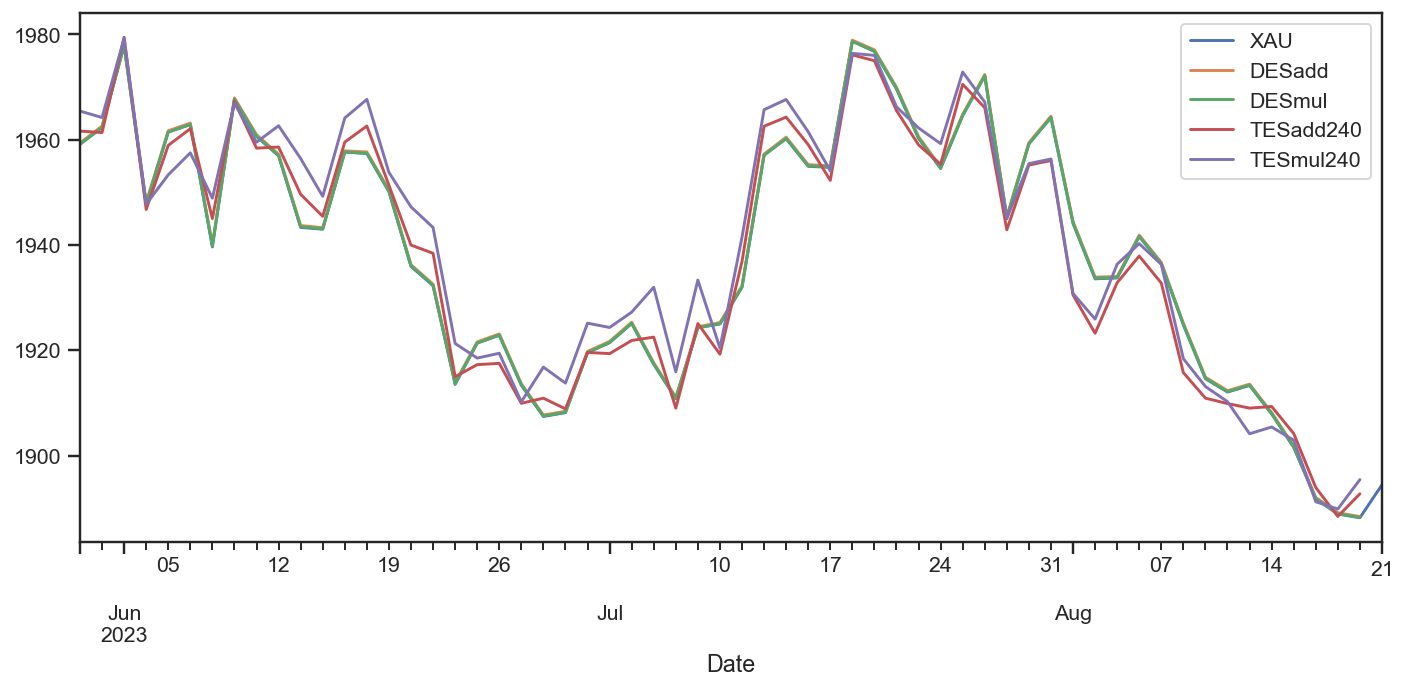

In [82]:
tdf[['XAU','DESadd', 'DESmul', 'TESadd240', 'TESmul240']].iloc[-60:].plot();

Looks like double exponential smoothing model has better results.

In [83]:
## Choose additive double exponential smoothing model
DES_model = ExponentialSmoothing(train['XAU'],trend='add').fit()

In [84]:
DES_pred = DES_model.forecast(94).rename('DES Forecast')
DES_pred

2023-04-12    2003.206270
2023-04-13    2003.342151
2023-04-14    2003.478032
2023-04-17    2003.613914
2023-04-18    2003.749795
                 ...     
2023-08-15    2015.299704
2023-08-16    2015.435585
2023-08-17    2015.571467
2023-08-18    2015.707348
2023-08-21    2015.843229
Freq: B, Name: DES Forecast, Length: 94, dtype: float64

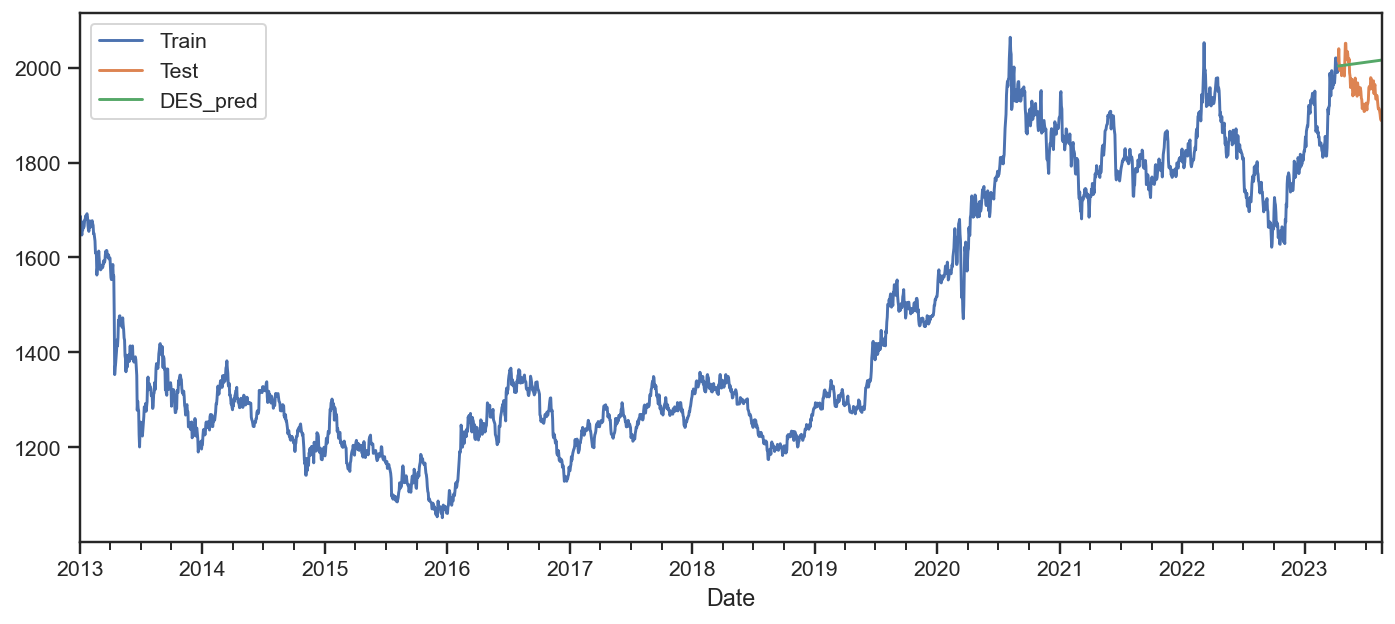

In [85]:
train['XAU'].plot(legend = True,label='Train')
test['XAU'].plot(legend = True,label='Test',figsize=(12,5))
DES_pred.plot(legend=True,label='DES_pred');

In [86]:
eval_metric(train,test,DES_pred)

Mean :1450.31
MAE : 55.95
Compare MAE with mean :3.86%
RMSE : 65.04
Compare RMSE with mean :4.48%


We can see the prediction is quite bad. Remember that double exponential smoothing forecast plot is still a straight line extending from the most recent value, but it has a slope. It also doesn't take seasonality into account.  

### ARIMA Models - Parameters Determination

There are two methods to decide the values of p,d, and q parameters for ARIMA model. We can read ACF and PACF plots, or use grid searches. 

p (AR term): The number of lag observations included in the model (PACF plot)

d (I term): The number of times that the raw observations are differenced 

q (MA term): The size of the moving average window, also called the order of moving average (ACF plot)

**ACF and PACF plots of differenced series reading rules :**
- To determine AR order(p) manully: If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive, then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms. 

- To determine MA order(q) manully: If the PACF displays a sharp cutoff while the ACF decays gradually, AR terms should be added rather than MA terms. 

- If ACF plot shows positive autocorrelation at the first lag(lag-1), AR terms in relation to the lag should be used. If the autocorrelation plot shows negative autocorrelaiton at the first lag, then it suggests using MA terms. 

- If PACF plot shows a sharp drop after lag "k" suggests AR-k model should be used. If there is a gradual decline, it suggests an MA model. 



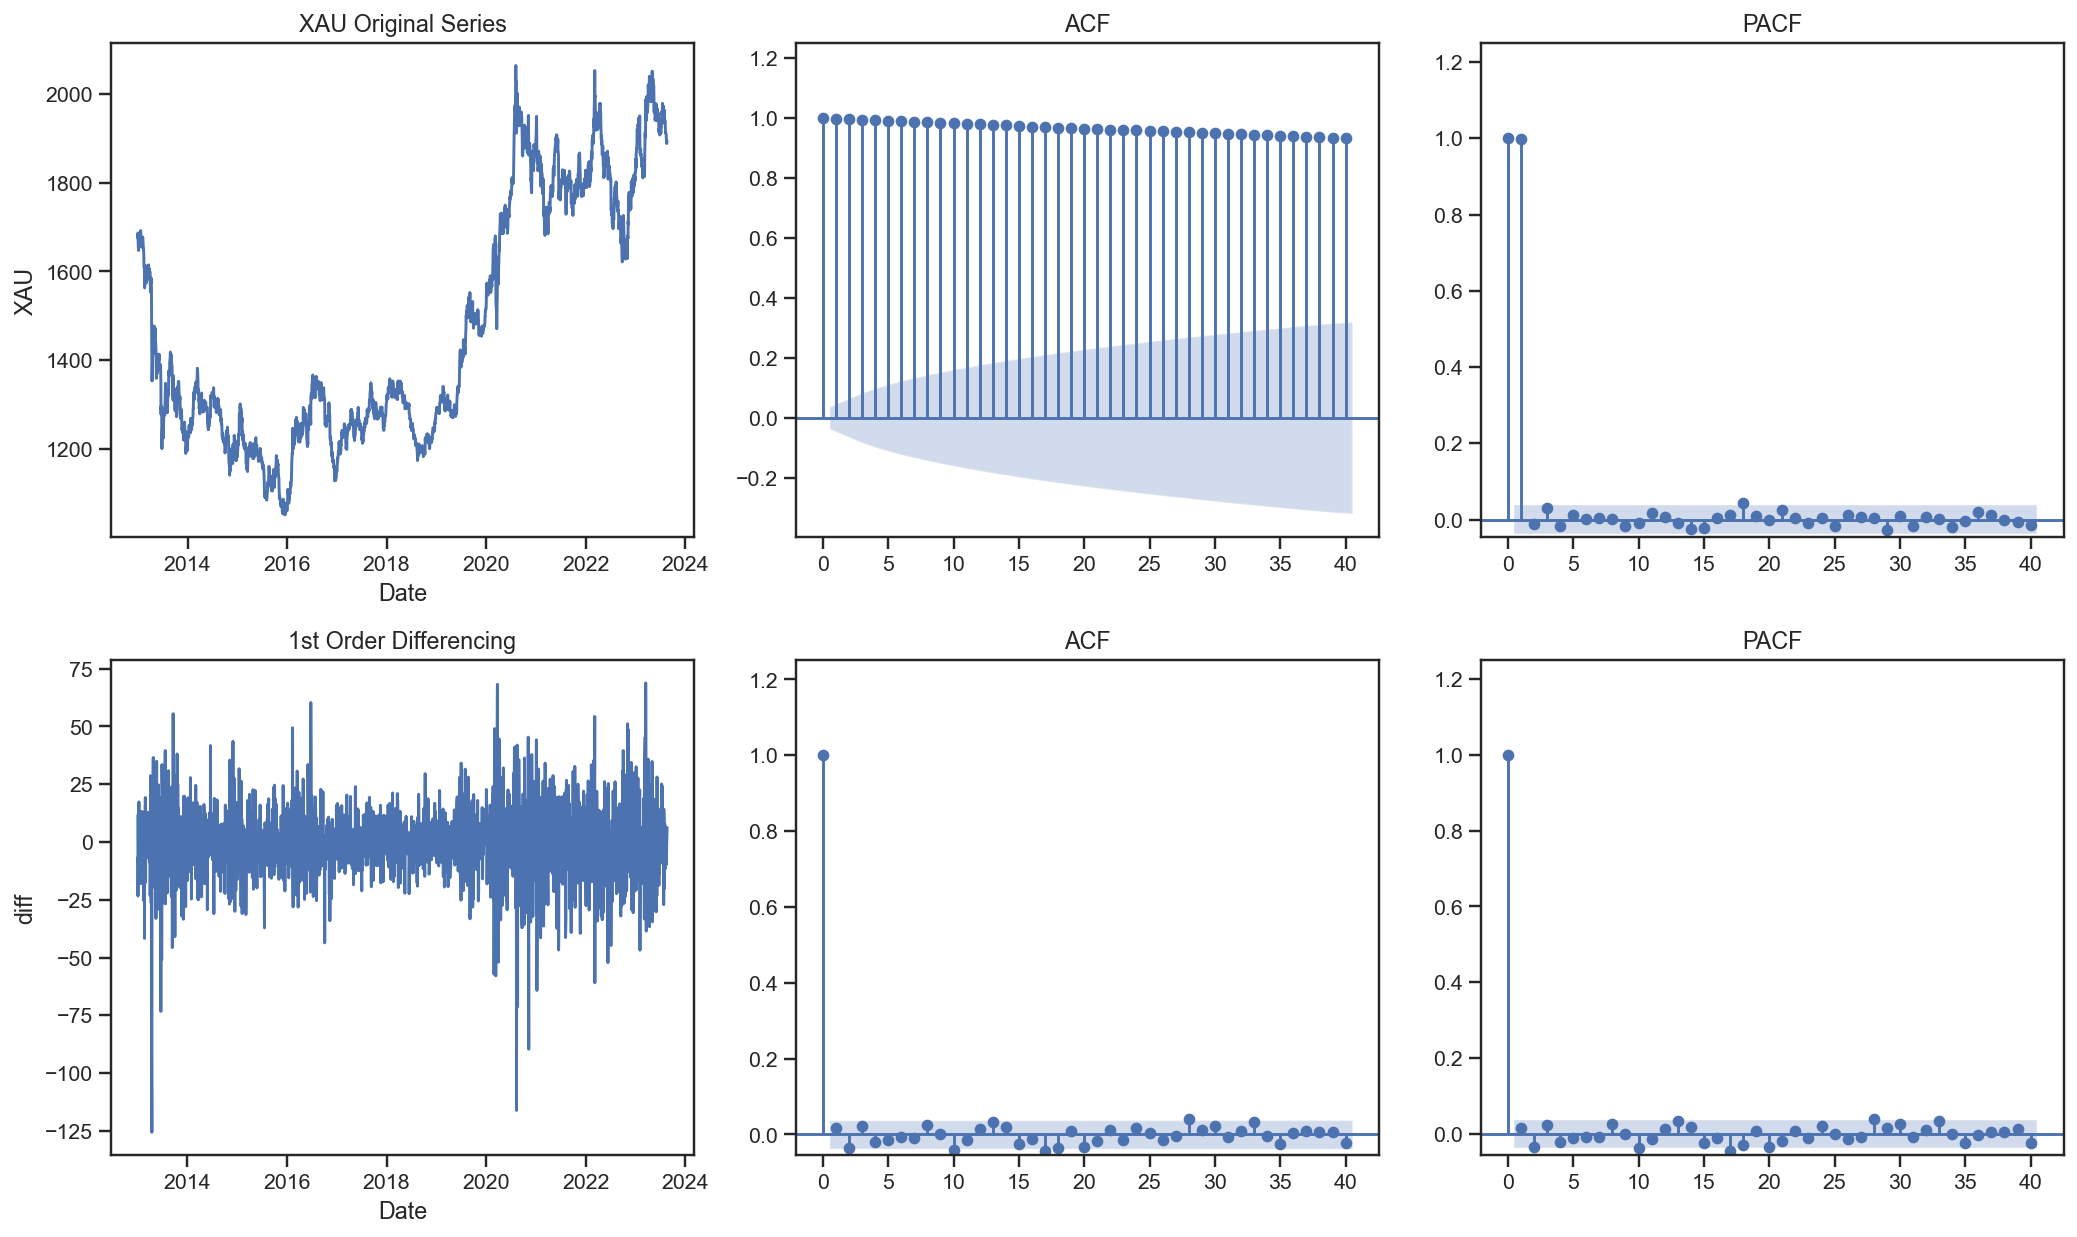

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
sns.lineplot(y='XAU', x='Date', data=tdf, ax=axes[0,0]).set_title("XAU Original Series");
plot_acf(tdf['XAU'], lags=40, ax=axes[0, 1],title='ACF',auto_ylims=True)
plot_pacf(tdf['XAU'], lags=40, ax=axes[0, 2],title='PACF',auto_ylims=True)

sns.lineplot(y='diff', x='Date', data=f_diff, ax=axes[1,0]).set_title("1st Order Differencing");
plot_acf(f_diff, lags=40, ax=axes[1, 1],title='ACF',auto_ylims=True)
plot_pacf(f_diff, lags=40, ax=axes[1, 2],title='PACF',auto_ylims=True)

plt.tight_layout()
plt.show();

**ACF and PACF reading for XAU (after 1st order differencing):**
- ACF plot shows a sharp drop after 0 ; q = 0
- PACF plot shows a sharp drop after 0 ; p = 0
- After 1st order differencing, data become stationary; d = 1

It can be very difficult to read these plots, so it is often more effective to perform a grid search across combinations of p,d, and q values. We are going to use pmdarima(Pyramid ARIMA) library to perform this grid searches. 

- pip install pmdarima

#### Auto - ARIMA (grid search)

In [88]:
from pmdarima import auto_arima

In [89]:
# help(auto_arima)
# Pass in the entire data set since we are only determing p,d,and q
# start_p = order of AR model
# start_q = order of MA model
# Use original data and set seasonal = False
stepwise_fit = auto_arima(tdf['XAU'],start_p = 0,start_q=0,
                          max_p = 4,max_q =4,
                          # we already use stationary data, so there's no seasonality
                          seasonal = False,
                          # trace = True shows the result of couple models
                          d =None, trace=True,
                         # not showing error if an order doesn't work
                         error_action='ignore',
                         # not showing covergence warnings
                         suppress_warnings = True,
                         # set to stepwise
                         stepwise = True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22511.830, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22513.121, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22513.066, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22509.918, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22511.316, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.012 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2775
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -11253.959
Date:                Mon, 04 Mar 2024   AIC                          22509.918
Time:                        15:29:41   BIC                          22515.846
Sample:                    01-01-2013   HQIC                         22512.059
                         - 08-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       195.5882      2.457     79.608      0.000     190.773     200.404
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              6153.35
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This shows a recommended (p,d,q) ARIMA order of (0,1,0), with no seasonal component. Auto-ARIMA results are consistent with (p,d,q) we picked out manually. 

In [90]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults

In [91]:
ARIMA_model = ARIMA(train['XAU'],order=(0,1,0))
results = ARIMA_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    XAU   No. Observations:                 2681
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -10873.145
Date:                Mon, 04 Mar 2024   AIC                          21748.290
Time:                        15:29:41   BIC                          21754.184
Sample:                    01-01-2013   HQIC                         21750.423
                         - 04-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       195.6668      2.470     79.225      0.000     190.826     200.507
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):              6351.55
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
ARIMA_pred = results.predict(start=start,end=end, dynamic =False, typ='levels').rename('ARIMA(0,1,0) Predictions')

In [93]:
prediction = test.copy()
prediction

,XAU
Date,
2023-04-12,2014.67
2023-04-13,2039.73
2023-04-14,2003.04
2023-04-17,1994.77
2023-04-18,2004.93
...,...
2023-08-15,1901.56
2023-08-16,1891.76
2023-08-17,1888.89


In [94]:
prediction['ARIMA(0,1,0) Predictions'] = ARIMA_pred
prediction

,XAU,"ARIMA(0,1,0) Predictions"
Date,,
2023-04-12,2014.67,2003.14
2023-04-13,2039.73,2003.14
2023-04-14,2003.04,2003.14
2023-04-17,1994.77,2003.14
2023-04-18,2004.93,2003.14
...,...,...
2023-08-15,1901.56,2003.14
2023-08-16,1891.76,2003.14
2023-08-17,1888.89,2003.14


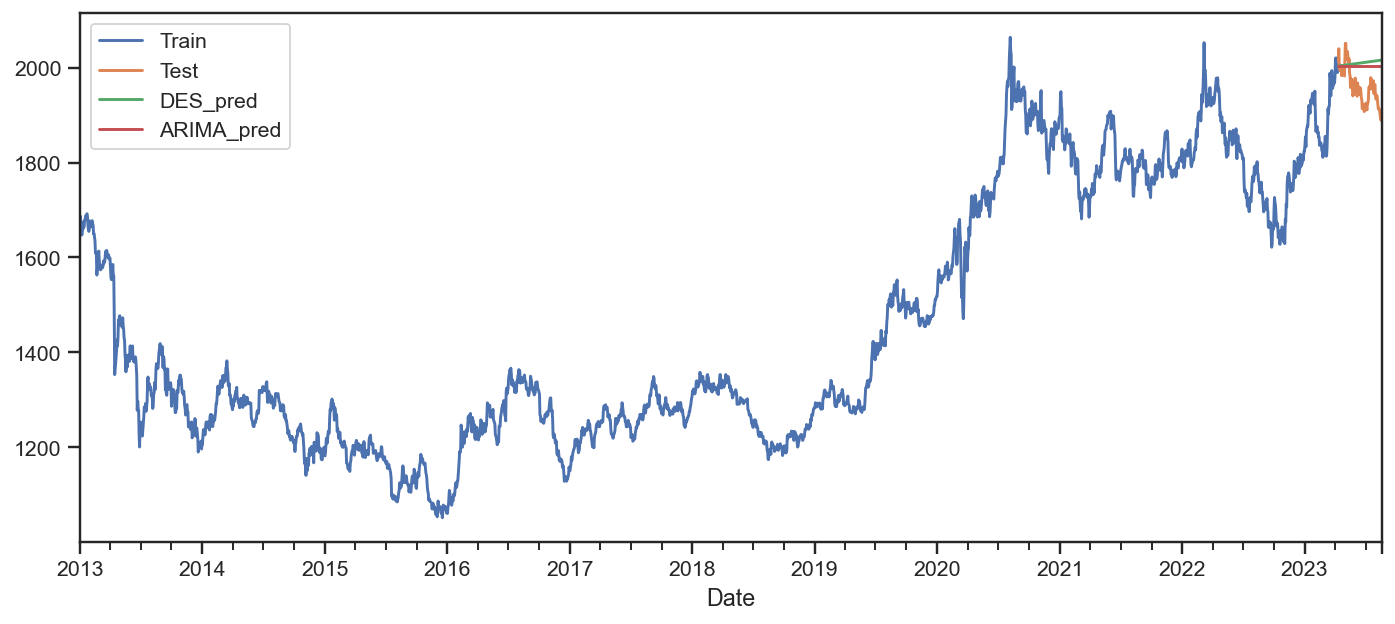

In [95]:
train['XAU'].plot(legend = True,label='Train')
test['XAU'].plot(legend = True,label='Test',figsize=(12,5))
DES_pred.plot(legend=True,label='DES_pred')
ARIMA_pred.plot(legend=True,label='ARIMA_pred');

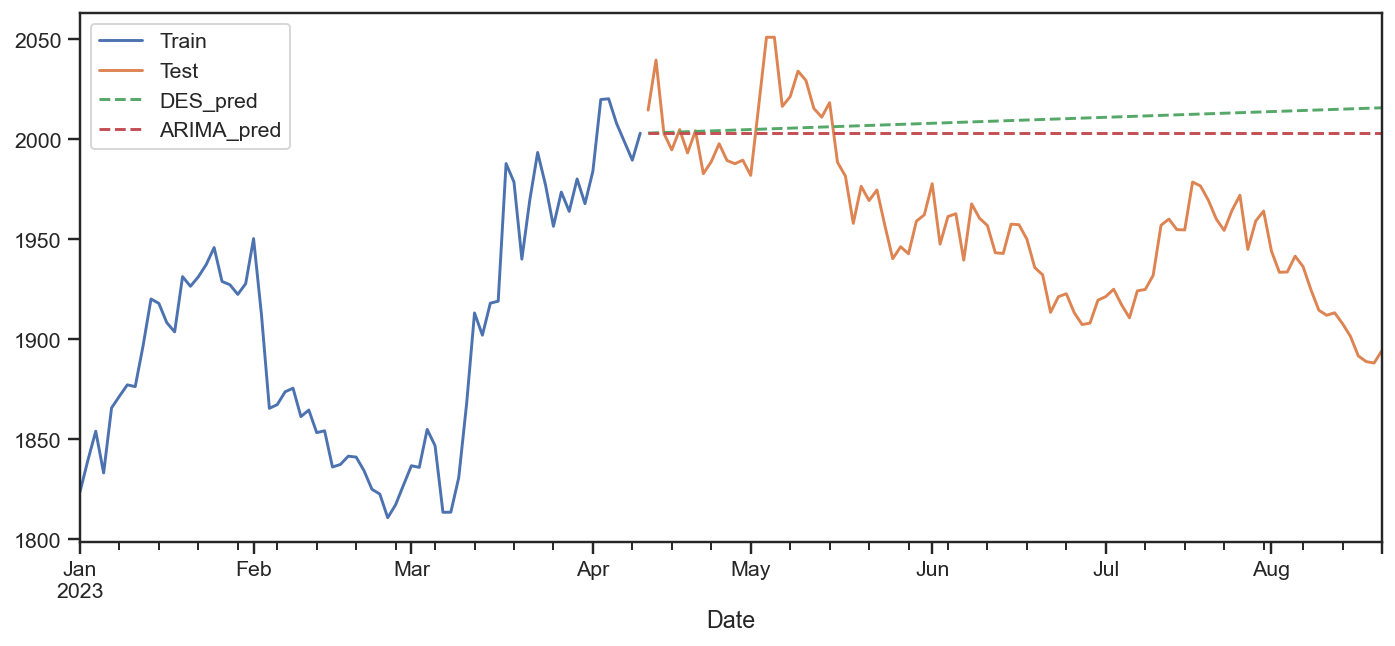

In [96]:
train['XAU']['2023-01-01':].plot(legend = True,label='Train')
test['XAU'].plot(legend = True,label='Test',figsize=(12,5))
DES_pred.plot(legend=True,label='DES_pred',style='--')
ARIMA_pred.plot(legend=True,label='ARIMA_pred',style='--');

In [97]:
eval_metric(train,test,ARIMA_pred)

Mean :1450.31
MAE : 50.15
Compare MAE with mean :3.46%
RMSE : 58.28
Compare RMSE with mean :4.02%


In [98]:
train['XAU'].iloc[-1]

2003.14

### Facebook Prophet Library
- pip install prophet

In [99]:
from prophet import Prophet

In [100]:
# Prepare data
pdf = tdf['XAU'].to_frame().reset_index()
pdf

,Date,XAU
0,2013-01-01,1675.15
1,2013-01-02,1686.75
2,2013-01-03,1663.35
3,2013-01-04,1656.85
4,2013-01-07,1647.25
...,...,...
2770,2023-08-15,1901.56
2771,2023-08-16,1891.76
2772,2023-08-17,1888.89
2773,2023-08-18,1888.19


In [101]:
# Change column names to prophet required format
pdf.columns = ['ds','y']

In [102]:
pdf['ds'] = pd.to_datetime(pdf['ds'])
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2775 non-null   datetime64[ns]
 1   y       2775 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.5 KB


In [103]:
# Train test split 
num = len(pdf)-94
num

2681

In [104]:
p_train = pdf.iloc[:num]
p_test = pdf.iloc[num:]
print(f" X_train shape :{p_train.shape}")
print(f" X_test shape :{p_test.shape}")

 X_train shape :(2681, 2)
 X_test shape :(94, 2)


In [105]:
# Create an instance for prophet
p = Prophet()
# Fit to training data
p.fit(p_train)
#period = test size
# Create a future dataframe
# Specify freq if it's not daily data
future = p.make_future_dataframe(periods = 94,freq='B')
forecast = p.predict(future)

15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:43 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2770,2023-08-15,1833.235006,1778.553672,1926.962806,1794.829071,1869.008954,17.079263,17.079263,17.079263,2.378543,2.378543,2.378543,14.700721,14.700721,14.700721,0.0,0.0,0.0,1850.314269
2771,2023-08-16,1833.283607,1776.359413,1925.502067,1793.617547,1869.702292,17.537383,17.537383,17.537383,2.263442,2.263442,2.263442,15.273941,15.273941,15.273941,0.0,0.0,0.0,1850.820990
2772,2023-08-17,1833.332208,1775.235257,1927.400299,1792.883605,1870.690952,18.371519,18.371519,18.371519,2.544993,2.544993,2.544993,15.826525,15.826525,15.826525,0.0,0.0,0.0,1851.703727
2773,2023-08-18,1833.380810,1771.768450,1936.183303,1791.821389,1871.580910,19.576908,19.576908,19.576908,3.221741,3.221741,3.221741,16.355167,16.355167,16.355167,0.0,0.0,0.0,1852.957718
2774,2023-08-21,1833.526614,1784.155225,1931.393526,1791.594246,1872.550626,20.342699,20.342699,20.342699,2.595333,2.595333,2.595333,17.747367,17.747367,17.747367,0.0,0.0,0.0,1853.869313


In [107]:
p_test.tail()

,ds,y
2770,2023-08-15,1901.56
2771,2023-08-16,1891.76
2772,2023-08-17,1888.89
2773,2023-08-18,1888.19
2774,2023-08-21,1894.44


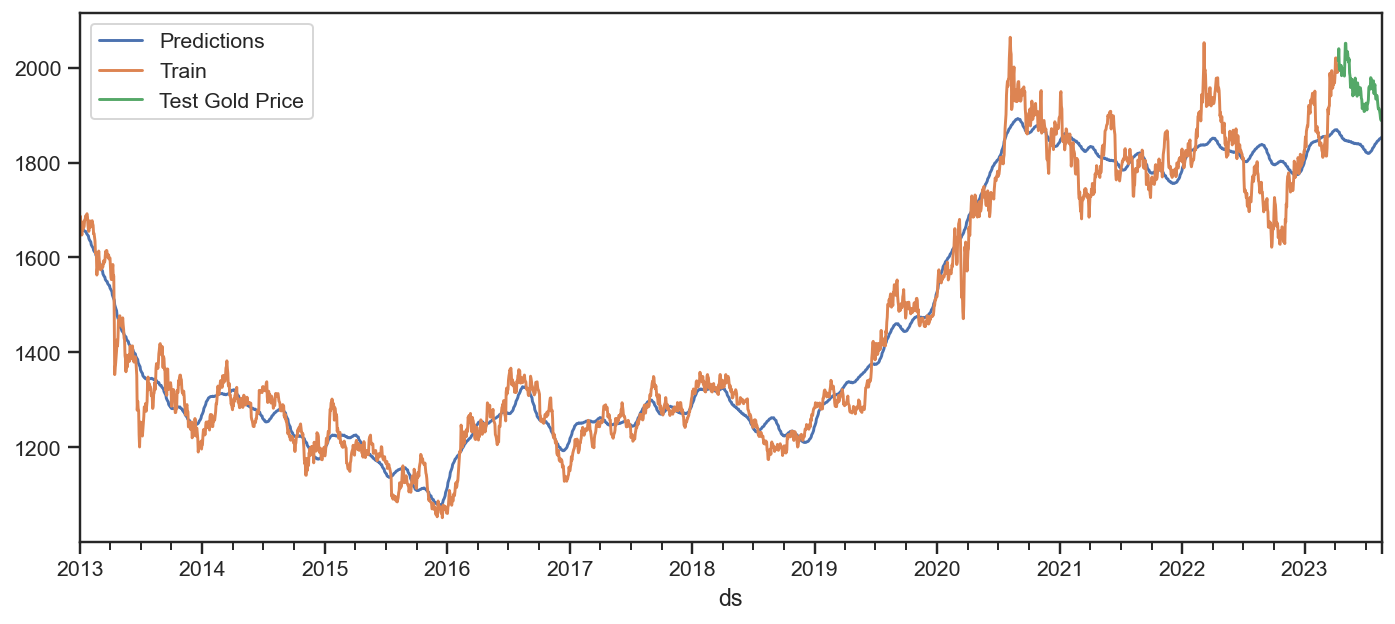

In [108]:
# Compare predictions and test data with graph
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,5))
# set to test lower and upper bonds
p_train.plot(x='ds',y='y',label='Train',ax=ax)
p_test.plot(x='ds',y='y',label='Test Gold Price',ax=ax);

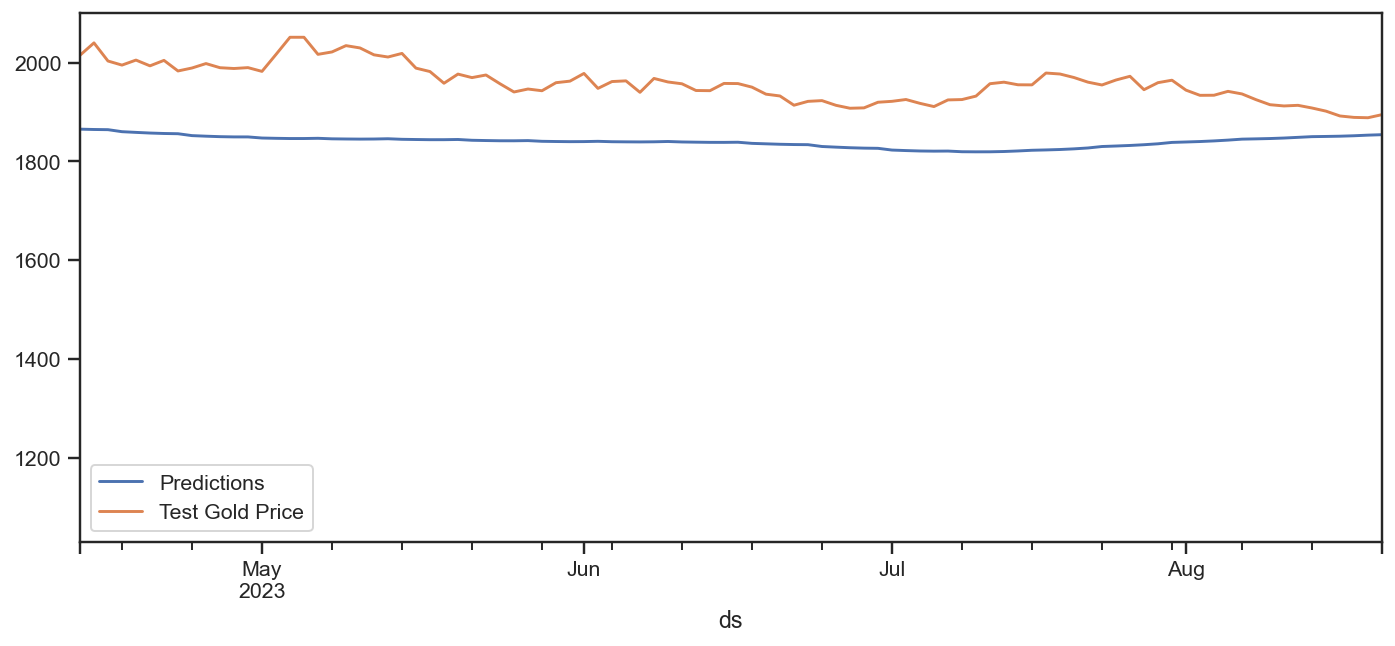

In [109]:
# Compare predictions and test data with graph
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,5))
# set to test lower and upper bonds
p_test.plot(x='ds',y='y',label='Test Gold Price',legend=True, ax=ax,xlim=('2023-04-12','2023-08-21'));

In [110]:
# grab prediction values
p_pred = forecast.iloc[-94:]['yhat']
p_pred

2681    1865.077882
2682    1864.395635
2683    1864.029801
2684    1859.954186
2685    1858.533299
           ...     
2770    1850.314269
2771    1850.820990
2772    1851.703727
2773    1852.957718
2774    1853.869313
Name: yhat, Length: 94, dtype: float64

In [111]:
eval_metric(train,test,p_pred)

Mean :1450.31
MAE : 119.08
Compare MAE with mean :8.21%
RMSE : 124.19
Compare RMSE with mean :8.56%


### LSTM (Deep learning)
#### RNN model
RNN is designed to work with sequence data. Therefore, using RNN model on Time series data is appropriate. 

#### Scaling  (Necessary for RNN)
With neural networks, since we are calculating biases and weights, if we have data that's too skewed(the smallest point is way lower than the highest point), neurons will be confused as far as what values of weights and biases to use. This is the reason why we need to scale the data.  

#### Timeseries Generator
Generate roll-in numbers. If n_input=2, n_features=1, that means it will generate first 2 values in the dataframe as one object, then the 3rd value as the second object. Basically, if we use the first 2 days gold price to predict the 3rd day's price, it generates the first 2 days' price as training data, and the 3rd day as target. It does this for all values in the dataframe. Therefore, len(generator) = len(df-n_input).

X, y = generator

#### Number of neurons 
https://www.youtube.com/watch?v=YhatZb5SzE0&ab_channel=M%C4%B1sraTurp

1. Input Layer
Determined based on input size 
- Images : each pixel is one neuron
  - 28 to 28 pixel image : 28*28 = 784 input neurons
- Table data : # of features = # of neurons

2. Output Layer
Determined based on the output type
- Male/Female : 
  - 0=female,1=male : 1 neuron
  - first one = female,second one = male : 2 neurons
- Regression 0-200 :
  - Single neuron with the appropriate activation function
  
3. Hidden Layer
It's better to have a deeper network than a wider network, meaning more layers are better than more neurons in each of these layers. Layers learn features from the data. The more layers you have, the more different layers of complexity you will be able to handle. 1-2 layers should be enough for many problems. Or you can start at 2 and work your way up. When you see overfitting, you can start making solutions or decreasing the amount of layers. For every layer you can have 100-300 neurons. 


In [112]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [113]:
scaler = MinMaxScaler()
# Only fit to training data
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [114]:
scaled_train

array([[0.61597518],
       [0.62743684],
       [0.60431591],
       ...,
       [0.9357999 ],
       [0.92672444],
       [0.94005355]])

In [115]:
scaled_train.shape

(2681, 1)

#### TimeseriesGenerator(data, targets, length,batch_size)

This generator takes in a sequence of data-points gathered at equal intervals to produce batches of data of training/validation. len(generator) = len(data)-n_input.

- Data : input trainig data (X)
- targets : predicting target (y)
- length : Length of the output sequences(in number of timesteps)
- batch_size = Number of timeseries samples in each batch 

batch_size should be small to prevent overfitting, but there's no correct answer. You can always experiment with all parameters. 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

In [116]:
# To see what generator does
generator = TimeseriesGenerator(scaled_train,scaled_train,length=5,batch_size=2)

In [117]:
scaled_train[:10]

array([[0.61597518],
       [0.62743684],
       [0.60431591],
       [0.59789343],
       [0.58840792],
       [0.60001779],
       [0.5989309 ],
       [0.61607399],
       [0.60401948],
       [0.60811999]])

In [118]:
X,y = generator[0]

In [119]:
X

array([[[0.61597518],
        [0.62743684],
        [0.60431591],
        [0.59789343],
        [0.58840792]],

       [[0.62743684],
        [0.60431591],
        [0.59789343],
        [0.58840792],
        [0.60001779]]])

In [120]:
X.shape

(2, 5, 1)

In [121]:
y[:5]

array([[0.60001779],
       [0.5989309 ]])

In [122]:
len(y)

2

In [123]:
# Now create the generator for our model
n_input = 100
# we only have one feature in the data (XAU)
n_features = 1

# Use 100 data points to predict the next data point(1~100 --> 101)
# our data and target come from the same data source
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

RNN_model = Sequential([
    LSTM(150, activation='relu',return_sequences=True,input_shape=(n_input,n_features)),
    LSTM(150, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(n_features)
])

RNN_model.compile(optimizer='adam',loss='mse',metrics='mean_absolute_error')

2024-03-04 15:29:49.551684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [124]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 150)          91200     
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 32)                4832      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 277,177
Trainable params: 277,177
Non-trainable params: 0
_________________________________________________________________


In [125]:
RNN_model.fit_generator(train_generator,epochs=25);

Epoch 1/25
2581/2581 [==============================] - 78s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0303
Epoch 2/25
2581/2581 [==============================] - 75s 29ms/step - loss: 8.1865e-04 - mean_absolute_error: 0.0212
Epoch 3/25
2581/2581 [==============================] - 74s 29ms/step - loss: 6.7764e-04 - mean_absolute_error: 0.0189
Epoch 4/25
2581/2581 [==============================] - 80s 31ms/step - loss: 5.3924e-04 - mean_absolute_error: 0.0171
Epoch 5/25
2581/2581 [==============================] - 84s 32ms/step - loss: 5.4520e-04 - mean_absolute_error: 0.0172
Epoch 6/25
2581/2581 [==============================] - 81s 31ms/step - loss: 4.5258e-04 - mean_absolute_error: 0.0158
Epoch 7/25
2581/2581 [==============================] - 82s 32ms/step - loss: 4.3576e-04 - mean_absolute_error: 0.0156
Epoch 8/25
2581/2581 [==============================] - 80s 31ms/step - loss: 3.8949e-04 - mean_absolute_error: 0.0143
Epoch 9/25
2581/2581 [==============================

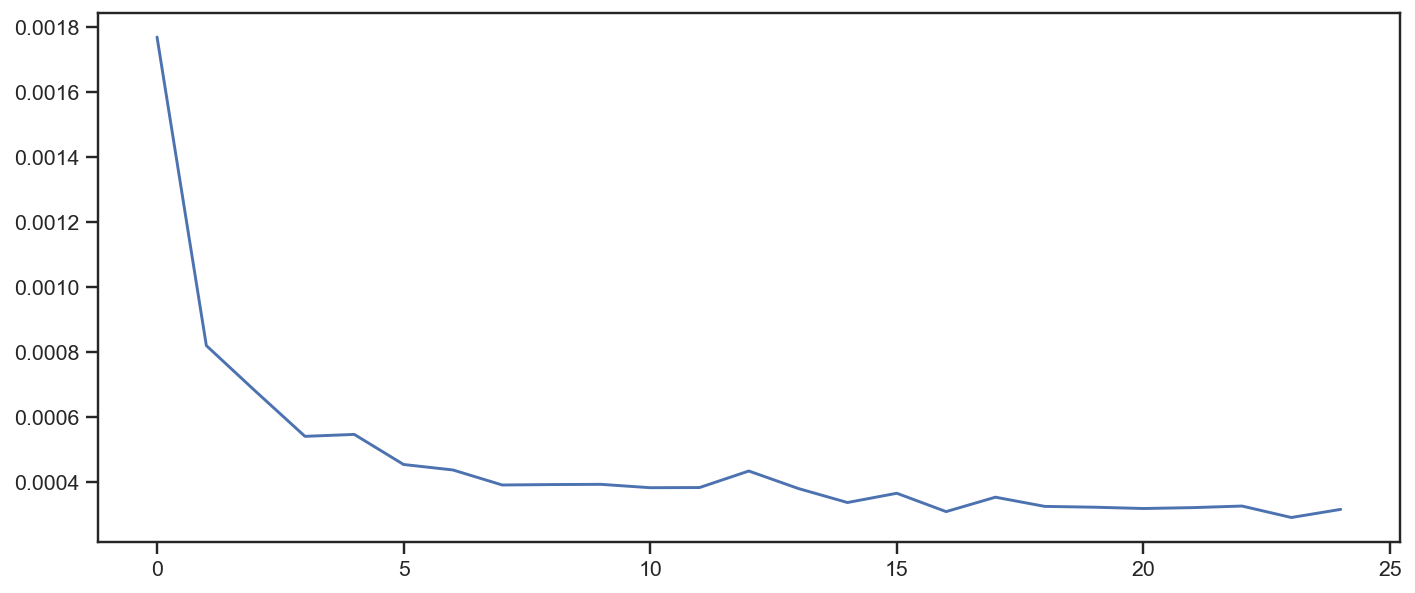

In [126]:
# Plot out loss
loss_per_epoch = RNN_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [127]:
# Create a list of test predictions
test_predictions = []

# Grab the last n_input values from training data
first_eval_batch = scaled_train[-n_input:]
# Reshape the data to the format RNN wants(same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# How far into the future will I forecast? 
# Here, we predict = the len of test data,94 
# You can always do more

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    # [0] is just for formatting
    # to get rid of double []
    current_pred = RNN_model.predict(current_batch)[0]
    
    # store current_pred to the list of test predictions
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    # np.append(arr, values, axis) : append the new value to the rest of the array
    # since current_batch's format is [[[A,B,C...]]] and current_pred is [D]
    # Add two additional [] for current_pred when appending
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [128]:
# tranform the scaled data to the original data form
RNN_predictions = scaler.inverse_transform(test_predictions)
prediction['RNN_pred'] = RNN_predictions
prediction

,XAU,"ARIMA(0,1,0) Predictions",RNN_pred
Date,,,
2023-04-12,2014.67,2003.14,1987.901384
2023-04-13,2039.73,2003.14,1972.147028
2023-04-14,2003.04,2003.14,1960.649139
2023-04-17,1994.77,2003.14,1949.079163
2023-04-18,2004.93,2003.14,1938.213229
...,...,...,...
2023-08-15,1901.56,2003.14,1528.387283
2023-08-16,1891.76,2003.14,1524.456265
2023-08-17,1888.89,2003.14,1520.509985


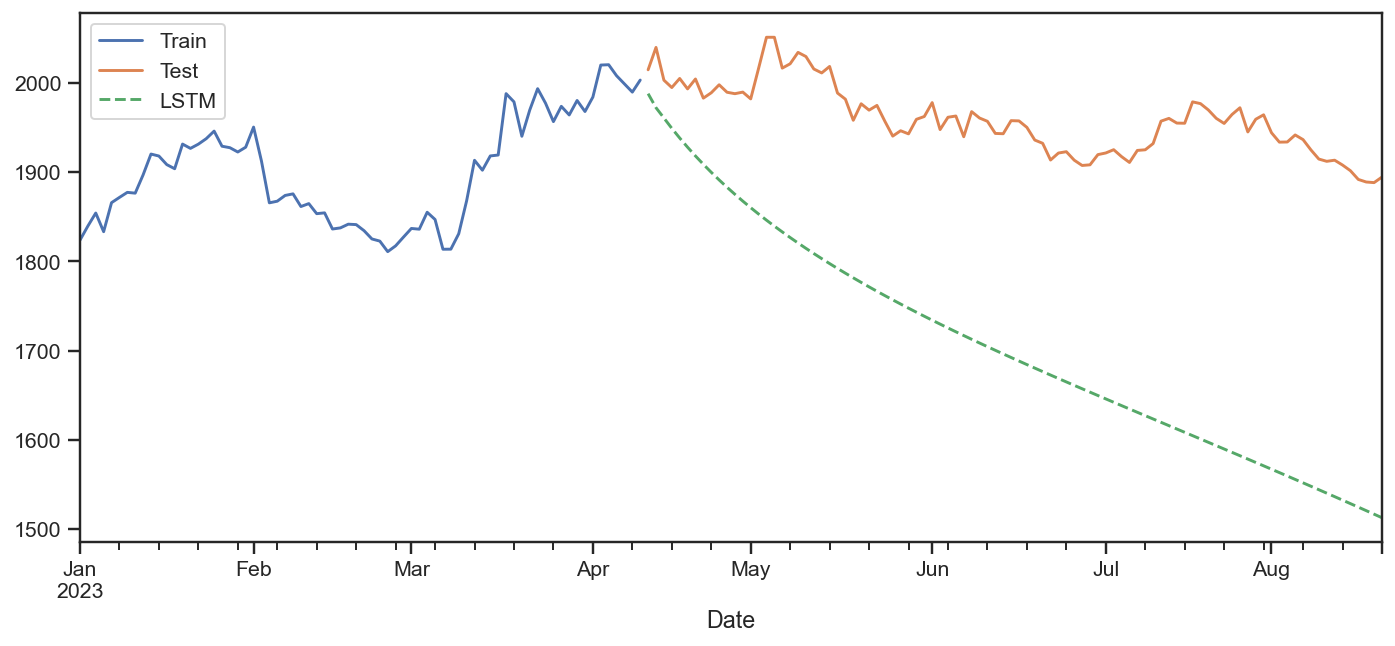

In [129]:
train['XAU']['2023-01-01':].plot(legend = True,label='Train')
test['XAU'].plot(legend = True,label='Test',figsize=(12,5))
prediction['RNN_pred'].plot(legend = True,label='LSTM',style='--');

In [130]:
eval_metric(train,test,RNN_predictions)

Mean :1450.31
MAE : 253.47
Compare MAE with mean :17.48%
RMSE : 272.01
Compare RMSE with mean :18.76%


In [131]:
fdf = tdf.drop(["diff","DESadd","DESmul","TESadd240","TESmul240"],axis=1)
fdf

,XAU
Date,
2013-01-01,1675.15
2013-01-02,1686.75
2013-01-03,1663.35
2013-01-04,1656.85
2013-01-07,1647.25
...,...
2023-08-15,1901.56
2023-08-16,1891.76
2023-08-17,1888.89


In [132]:
# Check whether the frequency of index is right
# also can use : fdf.index.frequency
fdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2775 entries, 2013-01-01 to 2023-08-21
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XAU     2775 non-null   float64
dtypes: float64(1)
memory usage: 107.9 KB


### Forecasting with Naive methods 
The most appropriate method for random walk models.

In [133]:
# Create columns of the mean and the last value of train data
prediction['Naive(mean)'] = train['XAU'].mean()
prediction['Naive(last value)'] = train['XAU'].iloc[-1]
prediction

,XAU,"ARIMA(0,1,0) Predictions",RNN_pred,Naive(mean),Naive(last value)
Date,,,,,
2023-04-12,2014.67,2003.14,1987.901384,1450.31389,2003.14
2023-04-13,2039.73,2003.14,1972.147028,1450.31389,2003.14
2023-04-14,2003.04,2003.14,1960.649139,1450.31389,2003.14
2023-04-17,1994.77,2003.14,1949.079163,1450.31389,2003.14
2023-04-18,2004.93,2003.14,1938.213229,1450.31389,2003.14
...,...,...,...,...,...
2023-08-15,1901.56,2003.14,1528.387283,1450.31389,2003.14
2023-08-16,1891.76,2003.14,1524.456265,1450.31389,2003.14
2023-08-17,1888.89,2003.14,1520.509985,1450.31389,2003.14


In [134]:
eval_metric(train,test,prediction['Naive(mean)'])

Mean :1450.31
MAE : 508.74
Compare MAE with mean :35.08%
RMSE : 510.16
Compare RMSE with mean :35.18%


In [135]:
eval_metric(train,test,prediction['Naive(last value)'])

Mean :1450.31
MAE : 50.15
Compare MAE with mean :3.46%
RMSE : 58.28
Compare RMSE with mean :4.02%


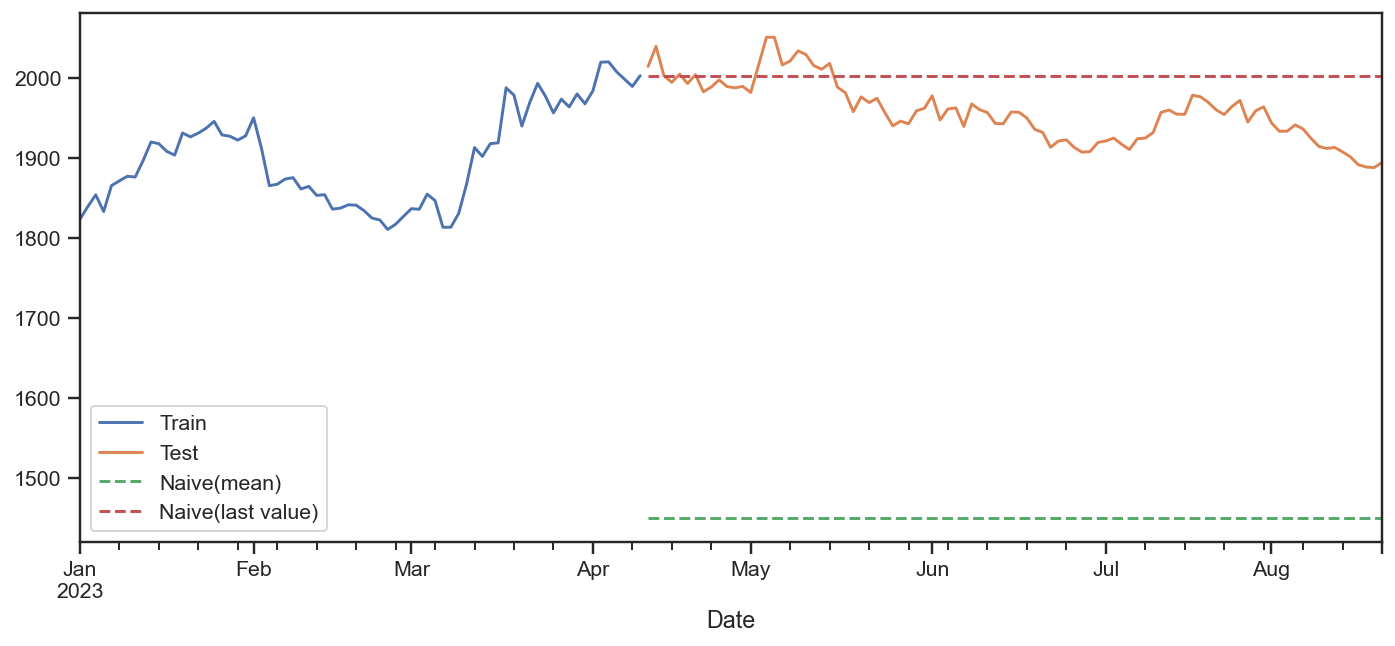

In [136]:
train['XAU']['2023-01-01':].plot(legend = True,label='Train')
test['XAU'].plot(legend = True,label='Test',figsize=(12,5))
prediction['Naive(mean)'].plot(legend = True,label='Naive(mean)',style='--')
prediction['Naive(last value)'].plot(legend = True,label='Naive(last value)',style='--');
#prediction['Drift'].plot(legend = True,label='Drift',style='--');

Although LSTM and Naive(last value) models produce the lowest errors(MAE and RMSE), Naive model is way more simple to apply. This proves that Naive model is the most appropriate forecasting model for gold price prediction or any random walk model.

The structure of a Random Walk is simple, next observation is equal to the last observed value plus a random noise

## Forecasting Unknown Future and Final Predictions

### Add and Prepare New Data

In [137]:
#Set date as our index and set it as a datetime data type
# parse_dates =True : Set date as a datetime index
final_test = pd.read_csv("/Users/emilychaukang/Desktop/DS/DS Projects/2. Gold Price Time Series Analysis/Final Data/XAU Final Test.csv"
                 ,index_col='Date',parse_dates=True)

In [138]:
final_test

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-02-26,2032.15,2034.10,2037.08,2025.14,NaN,-0.10%
2024-02-25,2034.09,2034.10,2035.06,2032.96,NaN,-0.08%
2024-02-23,2035.72,2024.49,2041.43,2015.55,NaN,0.57%
2024-02-22,2024.11,2025.24,2034.84,2019.70,NaN,-0.04%
2024-02-21,2024.99,2023.80,2032.22,2020.19,NaN,0.07%
...,...,...,...,...,...,...
2023-08-28,1919.66,1916.09,1926.19,1912.83,NaN,0.27%
2023-08-25,1914.53,1917.80,1923.09,1903.40,NaN,-0.11%
2023-08-24,1916.60,1914.15,1923.94,1911.35,NaN,0.12%


In [139]:
# Only grab Price column and sort the date
final_test = final_test['Price'].to_frame().sort_values(by='Date')
final_test

,Price
Date,
2023-08-22,1897.00
2023-08-23,1914.31
2023-08-24,1916.60
2023-08-25,1914.53
2023-08-28,1919.66
...,...
2024-02-21,2024.99
2024-02-22,2024.11
2024-02-23,2035.72


In [140]:
final_test.rename(columns={"Price":"XAU"},inplace=True)

In [141]:
# Make sure the index is in order
final_test.sort_index(inplace=True)

In [142]:
# There are no missing values
# 136 rows
# XAU dtype is strings
final_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2023-08-22 to 2024-02-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XAU     136 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [143]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2023-08-22 to 2024-02-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XAU     136 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [144]:
# Index is datetime object
# freq = None
final_test.index

DatetimeIndex(['2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31',
               '2023-09-01', '2023-09-04',
               ...
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-19',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-25', '2024-02-26'],
              dtype='datetime64[ns]', name='Date', length=136, freq=None)

In [146]:
# Set Frequency to business days
final_test.resample("B").sum()
print(f'# of rows after resampling: {len(final_test)}')
# Check the index of rows with 0 value
# There are none
interp = final_test[final_test['XAU']==0]
interp

# of rows after resampling: 136


,XAU
Date,


### Evaluation on LSTM and Naive model

#### Create The Final Model for LSTM (Just curious)

In [147]:
scaler = MinMaxScaler()
scaler.fit(fdf)
scaled_df = scaler.transform(fdf)

n_input = 100
n_features =1
f_generator = TimeseriesGenerator(scaled_df,scaled_df,length = n_input,batch_size=1)

final_LSTM = Sequential([
    LSTM(150, activation='relu',return_sequences=True,input_shape=(n_input,n_features)),
    LSTM(150, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(n_features)
])

final_LSTM.compile(optimizer='adam',loss='mse',metrics='mean_absolute_error')

In [148]:
final_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 150)          91200     
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dense_3 (Dense)             (None, 32)                4832      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 277,177
Trainable params: 277,177
Non-trainable params: 0
_________________________________________________________________


In [149]:
final_LSTM.fit_generator(f_generator,epochs=25)

Epoch 1/25
2675/2675 [==============================] - 88s 32ms/step - loss: 0.0022 - mean_absolute_error: 0.0307
Epoch 2/25
2675/2675 [==============================] - 81s 30ms/step - loss: 9.5724e-04 - mean_absolute_error: 0.0224
Epoch 3/25
2675/2675 [==============================] - 81s 30ms/step - loss: 6.3020e-04 - mean_absolute_error: 0.0187
Epoch 4/25
2675/2675 [==============================] - 81s 30ms/step - loss: 6.0485e-04 - mean_absolute_error: 0.0182
Epoch 5/25
2675/2675 [==============================] - 82s 31ms/step - loss: 5.7378e-04 - mean_absolute_error: 0.0175
Epoch 6/25
2675/2675 [==============================] - 84s 31ms/step - loss: 5.2883e-04 - mean_absolute_error: 0.0166
Epoch 7/25
2675/2675 [==============================] - 80s 30ms/step - loss: 3.9177e-04 - mean_absolute_error: 0.0148
Epoch 8/25
2675/2675 [==============================] - 83s 31ms/step - loss: 4.5192e-04 - mean_absolute_error: 0.0157
Epoch 9/25
2675/2675 [==============================

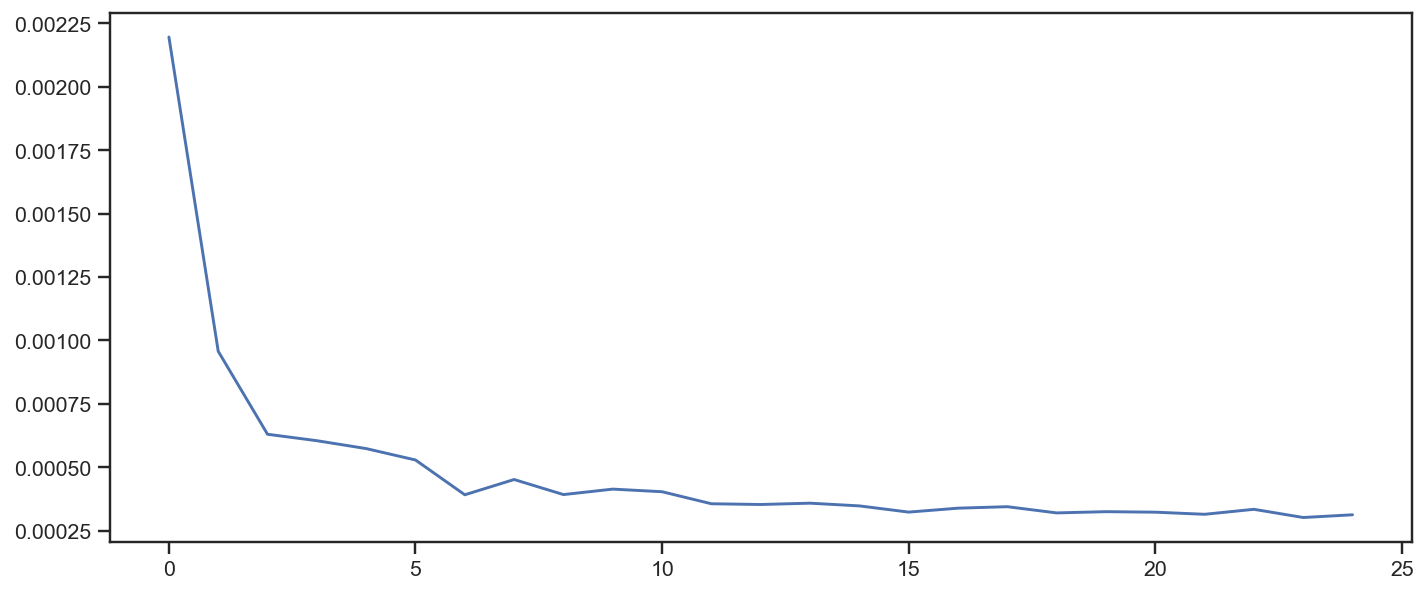

In [150]:
# Plot out loss
loss_per_epoch = final_LSTM.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [152]:
# Create a list of test predictions
LSTM_predictions = []

# Grab the last n_input values from training data
first_eval_batch = scaled_df[-n_input:]
# Reshape the data to the format RNN wants(same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# How far into the future will I forecast? 
# Here, we predict = the len of test data,94 
# You can always do more

for i in range(len(final_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    # [0] is just for formatting
    # to get rid of double []
    current_pred = final_LSTM.predict(current_batch)[0]
    
    # store current_pred to the list of test predictions
    LSTM_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    # np.append(arr, values, axis) : append the new value to the rest of the array
    # since current_batch's format is [[[A,B,C...]]] and current_pred is [D]
    # Add two additional [] for current_pred when appending
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


In [153]:
final_test

,XAU
Date,
2023-08-22,1897.00
2023-08-23,1914.31
2023-08-24,1916.60
2023-08-25,1914.53
2023-08-28,1919.66
...,...
2024-02-21,2024.99
2024-02-22,2024.11
2024-02-23,2035.72


In [154]:
# tranform the scaled data to the original data form
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)
final_test['LSTM_preds'] = LSTM_predictions
final_test

,XAU,LSTM_preds
Date,,
2023-08-22,1897.00,1898.549970
2023-08-23,1914.31,1901.681574
2023-08-24,1916.60,1904.956930
2023-08-25,1914.53,1908.116765
2023-08-28,1919.66,1911.166268
...,...,...
2024-02-21,2024.99,1979.789304
2024-02-22,2024.11,1979.794733
2024-02-23,2035.72,1979.799921


In [155]:
final_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2023-08-22 to 2024-02-26
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   XAU         136 non-null    float64
 1   LSTM_preds  136 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


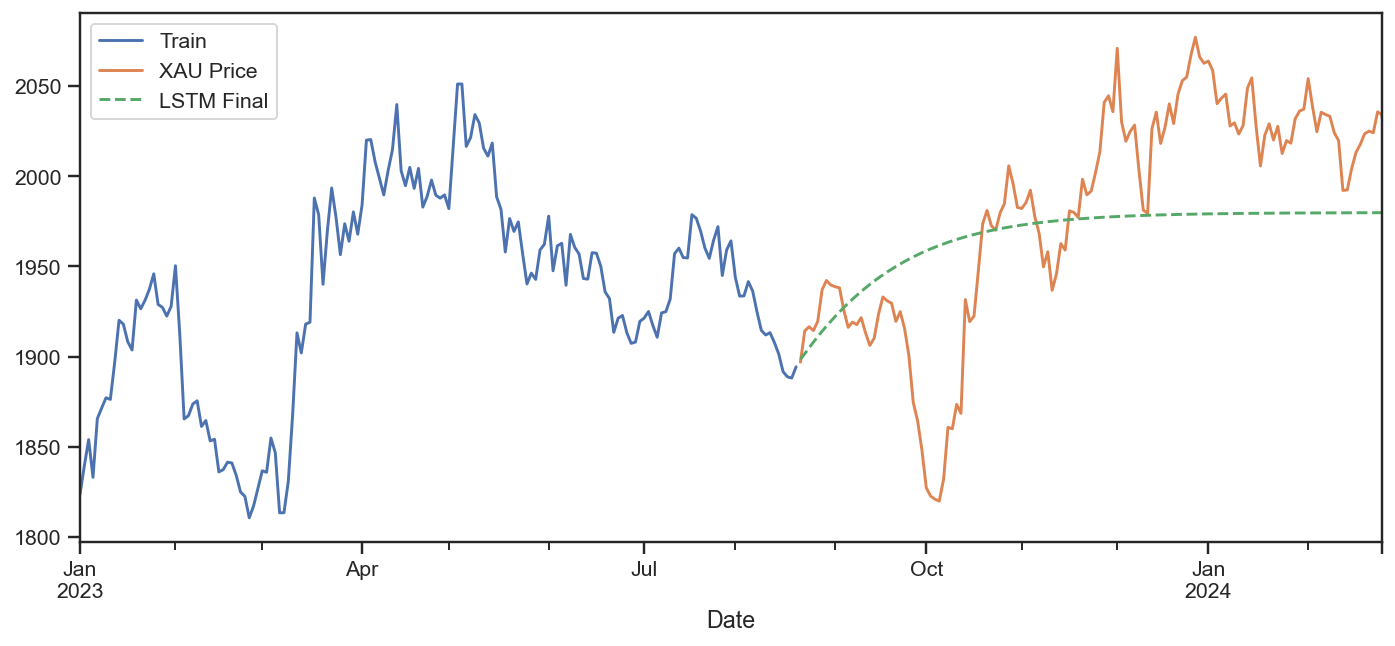

In [156]:
fdf['XAU']['2023-01-01':].plot(legend = True,label='Train')
final_test['XAU'].plot(legend = True,label='XAU Price',figsize=(12,5))
final_test['LSTM_preds'].plot(legend = True,label='LSTM Final',style='--');

In [157]:
eval_metric(fdf,final_test,LSTM_predictions)

Mean :1467.55
MAE : 43.18
Compare MAE with mean :2.94%
RMSE : 53.72
Compare RMSE with mean :3.66%


In [167]:
# Create columns of the last value of the complete data
final_test['Naive'] = fdf['XAU'].iloc[-1]
final_test

,XAU,LSTM_preds,Naive
Date,,,
2023-08-22,1897.00,1898.549970,1894.44
2023-08-23,1914.31,1901.681574,1894.44
2023-08-24,1916.60,1904.956930,1894.44
2023-08-25,1914.53,1908.116765,1894.44
2023-08-28,1919.66,1911.166268,1894.44
...,...,...,...
2024-02-21,2024.99,1979.789304,1894.44
2024-02-22,2024.11,1979.794733,1894.44
2024-02-23,2035.72,1979.799921,1894.44


In [161]:
eval_metric(fdf,final_test,final_test['Naive'])

Mean :1467.55
MAE : 94.16
Compare MAE with mean :6.42%
RMSE : 106.05
Compare RMSE with mean :7.23%


<AxesSubplot:xlabel='Date'>

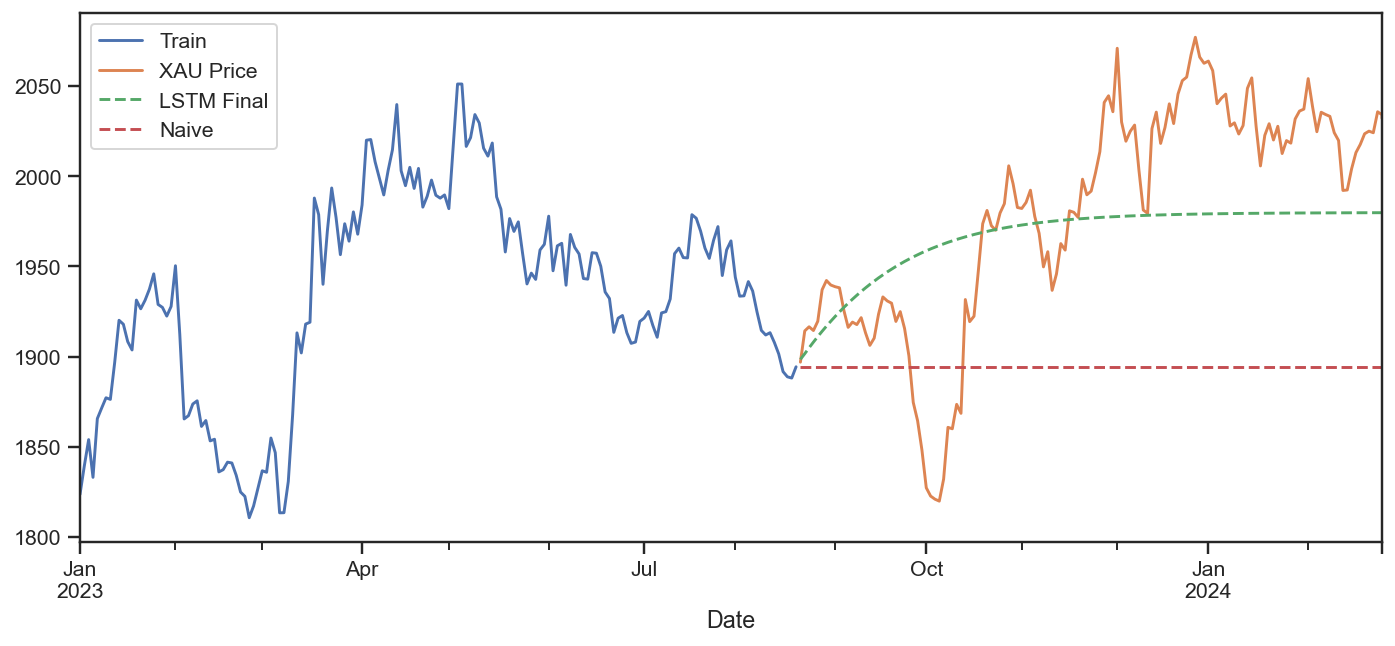

In [163]:
fdf['XAU']['2023-01-01':].plot(legend = True,label='Train')
final_test['XAU'].plot(legend = True,label='XAU Price',figsize=(12,5))
final_test['LSTM_preds'].plot(legend = True,label='LSTM Final',style='--')
final_test['Naive'].plot(legend = True,label='Naive',style='--')